Issues:
- We think one of the carcass 188 Lam has been mislabeled
Evidence: Number of differentially expressed loci is really low in Whole-fly in comparison to carcase.  T is low too, but not as low (though not completely comparable, because T does not have any 238 lines).  We would assume W to be some weighted average of T and C, but it's lower than both. 

Big questions
From the DESeq analysis, we know that there are differentially bound regions.  What do they look like?  Are they big/small, clustered/dispersed, the same across tissues?  Do they tend to be located near the telomeres, or the centromeres, or the rest of the genome?  Are they the same for Lam and D1?  Do they occur for genes with lots of tandem repeats?

Which model would best represent our data? Two possibilities:
1) Simple binary model where the protein either binds or doesn't. The base mean if the protein doesn't bind is low. The peaks of the non-NA regions generally speaking are non-overlapping.
2) Model that incorporate the degree of binding, assuming that the regions of binding relatively fixed. 
(Most likely a mix of these two things.  Depending on the results here, we might want to reduce our binding data 1's and 0's when comparing to gene expression. This might also impact whether we ultimately try to build an HMM, as an on/off an HMM is easy)

We do correlation between different datasets of BaseMean and Log2Change value, to find out whether areas of high binding the same across protein-line combos.  

We tested whether an interaction was significant by doing a NBLRT test in our DESeq analysis. Write a function that take a row number at which there is a significant interaction as input, and makes a plot of log2 fold change from individual line by protein by tissue analysis, and of log2fold change at surrounding regions for inividual line by protein by tissue combos.

Manhattan plot of -np.log10(p-values) across genomes (on raw pvalues). Color those with padj<.05 in diff color. 

Do ACF for these log2fold change for one line by protein tissue combination, or for the main effect of protein across pooled data.

RNA-seq: there is Y regulatory variation, but not particulary well structured in populations.
Preliminarly, we can say the same thing about this.  
As a control, we can say that the Dam-ID works and we can find regions of the genome that are particularly likely or unlikely to be bound by a certain protein. 
More interestingly, it's clear that there are regions of the genome where there is differential binding across lines, which suggests that hte Y chromosome does influence the way Lam and D1 interact with autosomes. 

SIMILAR TO WHAT WE DID FOR THE RNA-SEQ DATA, WE SHOULD JUST FILTER REGIONS OF THE GENOME THAT SHOW DIFF BINDING BY LINE.  WITHIN EACH BLOCK, RUN THE SAME CODE ON THE ADJUSTED P-VALUES ON THE LINE BY PROTEIN INTERACTION TEST AND THEN PICK THE MINIMIMUM PVAL FOR EACH BLOCK, AND GET THE LOG2FOLD CHANGE FO THAT PARTICULAR ROW FOR EACH LINE, AND THEN DO THE PCA FOR ALL OF THOSE ROWS.  THE PCA IS ON THE LOG2FOLD CHANGE.  THE IDEA IS TO SEE IF THERE IS ANY CLUSTERING BY COUNTRY.
not sure how informative that will be because there aren't a ton of regions that show this pattern.  
Main thing we want to do: find regions that show differential binding by line in each tissue by protein combo.  You can use code to identify the start position and end position of every block. (this is the first step for previous in caps lock)

Paper structure
Part A.  
1. RNA seq results: with sequencing we can identify YRV regions that are different among Y chromosomes but that tend to not cluster by county.  variance is as much within population and between population.
    a. the things we identify do overlap with previously identified YRV loci.
    b. control thing: identify that there is YRV, and what we identify is what has been identified previously.
    novel thing: not particularly structured by country.
    
PART B
2. control: We used the DAMID seq technique to identify regions of the genome in each line (in different tissues) that are differentially bound by different proteins.  
    a. point out issues with testes data
    b. particularly in carcass and whole genome we can identify regions of differential binding.  we describe these regions (distribution of the their length, etc).  these distributions vary depending on whether we're looking at D1 or Lam. 
3. Novel to this work: we id regions of the genome that are differentially bound among lines.  We should look at whether the variation is structure by country (this is what the PCA plot is for).  This is the stellate story.  We should look at the other regions and see if it makes sense based on what is known about the biology of these genes.  We can describe a handful of examples where we find evidence of differentially binding (for example stellate).  we'll probably focus on whole fly genome for this, we can look at carcass too, but manhattan plots for whole fly look cleanest.
Go to flybase.org, got to GBrowse, then in landmark or regions display: 
Chomo:start_position..end_position.  Those are from the location_df.
Just google the name.  Interactive fly usually has quite a nice description.

Ignore for now:
4. look at correlation between expression and LAM and D1 binding.  One thing would be to look at the correlation of log10 pvalues for the test of among line var in RNA sequence data and binding.  You would have to assign each row of the binding data to a gene.  If binding region in gene, assign to gene. Else drop from analysis.

In [1]:
%matplotlib inline

import glob
from string import letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import signal
from sklearn.decomposition import PCA

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Read locations dataframe -- this gives you actual location info for a given index

In [2]:
locations_df=pd.read_csv("Locations")
locations_df.head()

,Unnamed: 0,0,1,2
0,0,211000022278049,390,394
1,1,211000022278049,537,541
2,2,211000022278049,573,577
3,3,211000022278049,837,841
4,4,211000022278049,1613,1617


We look at the specific tissue by line by protein datasets (which had information about when there was significant different binding of the protein relative to Dam).  Here we load info for log2FoldChange and baseMean.


In [3]:
lFC=[]
lBM=[]
for f1 in glob.glob("res*"):
    df_FC = pd.read_csv(f1).log2FoldChange
    df_BM = pd.read_csv(f1).baseMean
    lFC.append(df_FC)
    lBM.append(df_BM)
log2FC = pd.concat(lFC, axis = 1)
baseM = pd.concat(lBM, axis = 1)

log2FC.columns= map(lambda x: x[8:], glob.glob("res*"))
log2FC.head()

baseM.columns= map(lambda x: x[8:], glob.glob("res*"))
baseM.head()


,C_D1_188,C_D1_238,C_D1_257,C_D1_89,C_Lam_188,C_Lam_238,C_Lam_257,C_Lam_89,T_D1_188,T_D1_238,...,T_Lam_257,T_Lam_89,W_D1_188,W_D1_238,W_D1_257,W_D1_89,W_Lam_188,W_Lam_238,W_Lam_257,W_Lam_89
0,0.632360,0.219583,0.617413,0.353553,1.423632,0.721288,1.313440,0.166012,1.382349,1.526687,...,0.942010,0.137624,0.667969,0.143726,0.611825,0.949658,0.649690,0.112728,0.568352,0.918350
1,0.444129,0.219583,0.502155,0.163913,1.013380,0.721288,1.087081,0.412760,1.208380,0.138335,...,0.646270,0.137624,0.825459,0.143726,0.310907,1.008575,0.829502,0.094104,0.521248,0.892944
2,0.444129,0.354546,0.502155,0.163913,1.013380,0.889381,0.923345,0.412760,1.323238,0.138335,...,0.646270,0.137624,0.825459,0.143726,0.310907,1.008575,0.829502,0.221549,0.521248,0.892944
3,0.514814,0.716185,0.797342,0.163913,0.410957,1.076175,0.829917,0.246748,0.711324,0.000000,...,0.080143,0.137624,0.785790,0.449538,0.681006,0.460453,0.431993,0.430985,0.323789,0.836915
4,1.048009,0.134962,0.598488,0.516430,1.459705,0.168094,0.788619,1.235139,0.363386,0.293382,...,0.761525,0.137624,0.327046,0.000000,0.462001,0.274345,0.379232,0.127445,0.667081,0.773114


## Looking at correlations

We plot the correlation of the log2FoldChange and the baseMean across these datasets, to see if the degree of binding was roughly the same across datasets, or if it was different.

In [3]:
log2FC.corr()

,C_D1_188,C_D1_238,C_D1_257,C_D1_89,C_Lam_188,C_Lam_238,C_Lam_257,C_Lam_89,T_D1_188,T_D1_238,...,T_Lam_257,T_Lam_89,W_D1_188,W_D1_238,W_D1_257,W_D1_89,W_Lam_188,W_Lam_238,W_Lam_257,W_Lam_89
C_D1_188,1.000000,0.084448,0.185538,0.048137,-0.236155,0.147122,0.126471,0.100072,0.032885,0.049706,...,0.079340,0.065715,0.141441,0.013264,0.145848,0.137106,-0.065214,-0.010504,-0.075181,-0.066353
C_D1_238,0.084448,1.000000,0.054228,0.178134,0.096437,-0.271294,0.027396,0.030398,-0.011205,0.077221,...,0.066633,0.081086,0.021483,-0.058588,0.024476,0.008022,0.036317,0.055740,0.026648,0.053927
C_D1_257,0.185538,0.054228,1.000000,-0.029868,-0.030861,0.033059,-0.262717,0.078458,0.052346,0.073161,...,0.045715,0.126250,0.083694,0.088210,0.077190,0.068603,-0.023298,-0.027299,-0.006077,-0.034937
C_D1_89,0.048137,0.178134,-0.029868,1.000000,0.089943,-0.049428,0.021883,-0.339638,0.058320,0.095046,...,0.047720,0.048361,-0.044062,-0.089370,-0.041100,-0.041480,0.047073,0.054313,0.025007,0.052549
C_Lam_188,-0.236155,0.096437,-0.030861,0.089943,1.000000,0.038597,0.143786,0.263221,-0.095147,-0.072434,...,0.366718,0.290739,-0.208459,-0.211461,-0.117651,-0.174313,0.587279,0.538894,0.557407,0.599971
C_Lam_238,0.147122,-0.271294,0.033059,-0.049428,0.038597,1.000000,0.587456,0.490667,-0.074636,-0.045656,...,0.341898,0.114237,0.215834,-0.065040,0.319535,0.245201,0.147050,0.283936,0.120696,0.134042
C_Lam_257,0.126471,0.027396,-0.262717,0.021883,0.143786,0.587456,1.000000,0.447122,-0.134005,-0.059359,...,0.369278,0.140999,0.193976,-0.070884,0.303794,0.229505,0.247107,0.375128,0.227882,0.243468
C_Lam_89,0.100072,0.030398,0.078458,-0.339638,0.263221,0.490667,0.447122,1.000000,-0.096992,-0.040236,...,0.381550,0.246954,0.118756,-0.081556,0.211372,0.135516,0.294164,0.373508,0.280298,0.301677
T_D1_188,0.032885,-0.011205,0.052346,0.058320,-0.095147,-0.074636,-0.134005,-0.096992,1.000000,0.062777,...,-0.050076,-0.011687,0.008955,0.059679,-0.049022,-0.024542,-0.081879,-0.106526,-0.059483,-0.076827
T_D1_238,0.049706,0.077221,0.073161,0.095046,-0.072434,-0.045656,-0.059359,-0.040236,0.062777,1.000000,...,-0.071289,0.082057,0.009627,-0.054659,-0.012420,-0.030668,-0.136431,-0.089706,-0.127408,-0.130686


In [4]:
baseM.corr()

,C_D1_188,C_D1_238,C_D1_257,C_D1_89,C_Lam_188,C_Lam_238,C_Lam_257,C_Lam_89,T_D1_188,T_D1_238,...,T_Lam_257,T_Lam_89,W_D1_188,W_D1_238,W_D1_257,W_D1_89,W_Lam_188,W_Lam_238,W_Lam_257,W_Lam_89
C_D1_188,1.000000,0.859699,0.903500,0.577807,0.852653,0.772056,0.774150,0.660527,0.528178,0.323899,...,0.823847,0.662813,0.669003,0.659415,0.668474,0.685167,0.530939,0.588978,0.528623,0.553801
C_D1_238,0.859699,1.000000,0.901065,0.676946,0.716033,0.821480,0.642490,0.745046,0.486028,0.290582,...,0.754179,0.715831,0.626257,0.615334,0.636833,0.647831,0.484984,0.552071,0.465054,0.505133
C_D1_257,0.903500,0.901065,1.000000,0.582605,0.779976,0.739546,0.743071,0.627464,0.505470,0.318214,...,0.759417,0.606799,0.713839,0.702525,0.719247,0.729906,0.552480,0.619852,0.535842,0.571464
C_D1_89,0.577807,0.676946,0.582605,1.000000,0.467507,0.572935,0.420523,0.707966,0.359975,0.213704,...,0.537993,0.524421,0.379670,0.377214,0.384651,0.392144,0.304663,0.345675,0.293306,0.315931
C_Lam_188,0.852653,0.716033,0.779976,0.467507,1.000000,0.730718,0.814699,0.626053,0.431985,0.268317,...,0.746451,0.654316,0.627810,0.628546,0.627767,0.627590,0.608568,0.624379,0.617704,0.628959
C_Lam_238,0.772056,0.821480,0.739546,0.572935,0.730718,1.000000,0.782970,0.777930,0.431575,0.234671,...,0.712090,0.718558,0.515164,0.515989,0.519875,0.522511,0.462207,0.493282,0.470289,0.478090
C_Lam_257,0.774150,0.642490,0.743071,0.420523,0.814699,0.782970,1.000000,0.555391,0.419657,0.277471,...,0.723670,0.568403,0.599821,0.597927,0.590711,0.601307,0.565062,0.592005,0.587124,0.586305
C_Lam_89,0.660527,0.745046,0.627464,0.707966,0.626053,0.777930,0.555391,1.000000,0.373564,0.172891,...,0.645149,0.702593,0.399463,0.400888,0.405663,0.403442,0.374020,0.389142,0.372713,0.384320
T_D1_188,0.528178,0.486028,0.505470,0.359975,0.431985,0.431575,0.419657,0.373564,1.000000,0.274286,...,0.514618,0.403302,0.411945,0.401735,0.407227,0.425194,0.330294,0.363460,0.327453,0.348137
T_D1_238,0.323899,0.290582,0.318214,0.213704,0.268317,0.234671,0.277471,0.172891,0.274286,1.000000,...,0.363059,0.221894,0.302990,0.292537,0.290654,0.317452,0.231508,0.267992,0.229819,0.251445


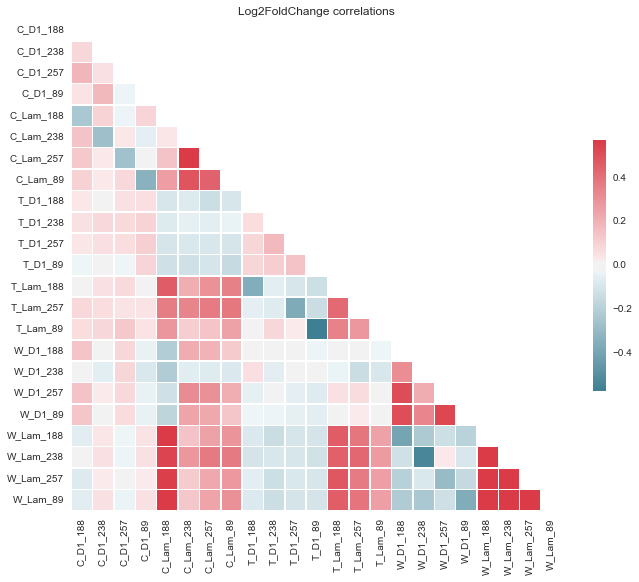

In [5]:
#https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html

sns.set(style="white")

corr=log2FC.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title("Log2FoldChange correlations")

Lam binding in general positively correlated across tissue types.

Places were Lam binds negatively correlated to places where D1 binds.  This is particularly obvious when comparing C_Lam_188 to C_D1_188, C_Lam_238 to C_D1_238, T_Lam_89 to T_D1_89.  ie, the blue diagonal lines, where tissue and line kept the same, just protein different.  But these are just ratios with a same denominator, so that can do weird things to the correlation - but you wouldn't really expect it to be negative, and also there was shrinkage so we shouldn't really expect this to happen.  

This neg correlation is a little unexpected, because in previous work, Lam and D1 are correlated.  We should ask Lene about C_Lam_188 -- maybe it is in fact a mislabeled W.  That might explain the lack of differential binding in C-Lam, whereas there isn't in W_Lam and T_Lam?  Because if C_Lam is actually W, then among line variation within C is in fact reflecting C vs W variation.

In 20160519_DESeq_DamID-Copy1, we showed that W-Lam does not show much differential binding, although C-Lam did.  This was puzzling. We thought that W-Lam should be an average of carcass and testes, more weighted toward carcass.  We thought that maybe C-Lam and T-Lam were negatively correlated with each other, but they are slightly positively correlated.

In general, not a lot of signal for testes.

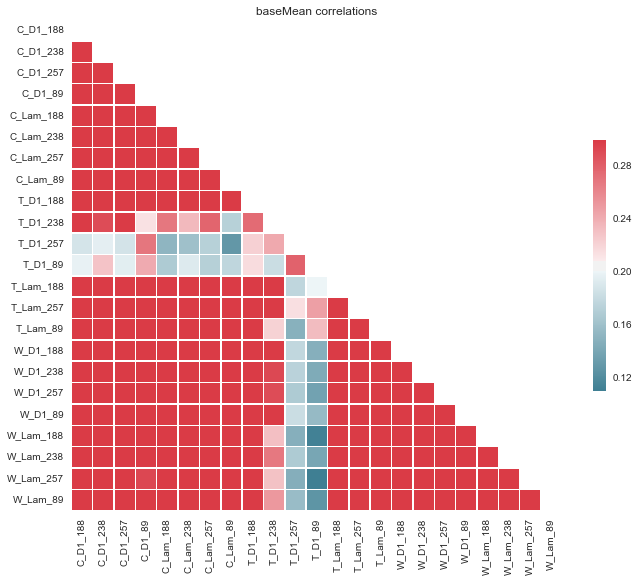

In [157]:
sns.set(style="white")

corr=baseM.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title("baseMean correlations")

not a lot to see in the above graph, except T_D1 negatively correlated with everything else.  In general, T-D1 didn't show much significant binding (see histogram of p-values).

Testes D1 is not very correlated even with itself.  One issue with the testes sample is that in a few cases there were issues with the library prep (extra PCR cycles had been run, which can cause biases.)
188 looks reasonable, but the rest don't look good.  Maybe we should just remove testes D1 data.  You expect the baseMean to be correlated because a large part of the correlation for Base Mean determined by the binding of the Dam only control.  So if it's not correlated, then we worry about how good the control data is.

REMOVE TESTES D1. OR ANALYZE BUT KEEP IN MIND THAT DATA NOT VERY GOOD.

## Plotting PCA

The two outlier points that we see (bottom right and top right) are both testes data.  This makes again the case that testes data just isn't very good.  Also they're both T 89, which was a particularly bad one based on baseMean corr plot.

In [5]:
print log2FC.shape
log2FC.dropna().shape

(388464, 23)


(203990, 23)

In [291]:
print [str(ele) for ele in log2FC.columns]

['C_D1_188', 'C_D1_238', 'C_D1_257', 'C_D1_89', 'C_Lam_188', 'C_Lam_238', 'C_Lam_257', 'C_Lam_89', 'T_D1_188', 'T_D1_238', 'T_D1_257', 'T_D1_89', 'T_Lam_188', 'T_Lam_257', 'T_Lam_89', 'W_D1_188', 'W_D1_238', 'W_D1_257', 'W_D1_89', 'W_Lam_188', 'W_Lam_238', 'W_Lam_257', 'W_Lam_89']


In [7]:
pca = PCA(n_components=4)
X = pca.fit_transform(log2FC.dropna().transpose())

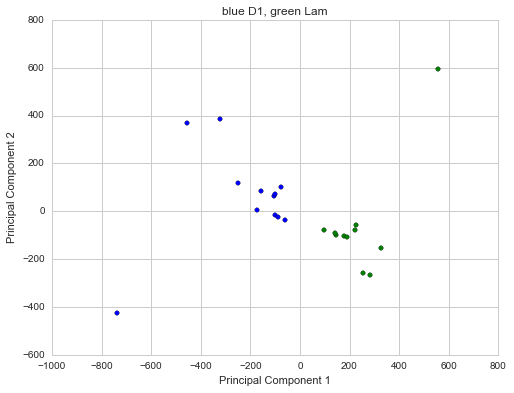

In [9]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 6))
    d={"blue":"D1", "green":"Lam"}
    for i, lab in enumerate(['C_D1_188', 'C_D1_238', 'C_D1_257', 'C_D1_89', 'C_Lam_188', 'C_Lam_238', 'C_Lam_257', 'C_Lam_89', 'T_D1_188', 'T_D1_238', 'T_D1_257', 'T_D1_89', 'T_Lam_188', 'T_Lam_257', 'T_Lam_89', 'W_D1_188', 'W_D1_238', 'W_D1_257', 'W_D1_89', 'W_Lam_188', 'W_Lam_238', 'W_Lam_257', 'W_Lam_89']):
        if 'D1' in lab:
            col="blue"
        else:
            col="green"
        plt.scatter(X[i, 0],
                    X[i, 1],
                    label=d[col],
                    c=col)
        #plt.annotate(lab,X[i, 0],X[i, 1])
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title("blue D1, green Lam")
    
    #plt.legend(loc='lower left')
    plt.show()

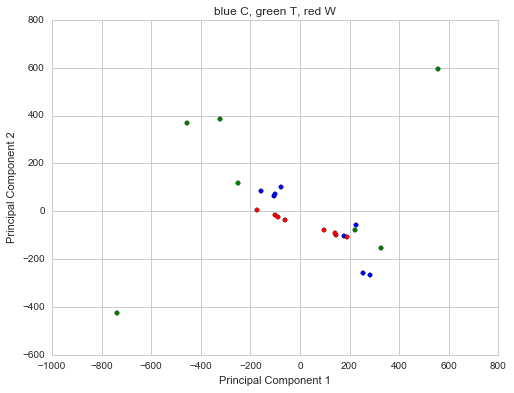

In [10]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 6))
    for i, lab in enumerate(['C_D1_188', 'C_D1_238', 'C_D1_257', 'C_D1_89', 'C_Lam_188', 'C_Lam_238', 'C_Lam_257', 'C_Lam_89', 'T_D1_188', 'T_D1_238', 'T_D1_257', 'T_D1_89', 'T_Lam_188', 'T_Lam_257', 'T_Lam_89', 'W_D1_188', 'W_D1_238', 'W_D1_257', 'W_D1_89', 'W_Lam_188', 'W_Lam_238', 'W_Lam_257', 'W_Lam_89']):
        if 'C' in lab:
            col="blue"
        elif "T" in lab:
            col="green"
        else:
            col="red"
        plt.scatter(X[i, 0],
                    X[i, 1],
                    c=col)
        #plt.annotate(lab,X[i, 0],X[i, 1])
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title("blue C, green T, red W")
    
    #plt.legend(loc='lower left')
    plt.show()

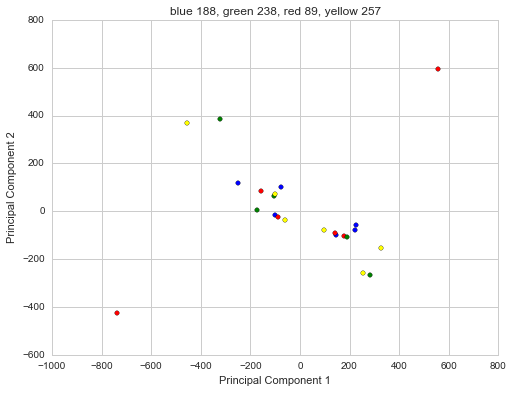

In [11]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 6))
    for i, lab in enumerate(['C_D1_188', 'C_D1_238', 'C_D1_257', 'C_D1_89', 'C_Lam_188', 'C_Lam_238', 'C_Lam_257', 'C_Lam_89', 'T_D1_188', 'T_D1_238', 'T_D1_257', 'T_D1_89', 'T_Lam_188', 'T_Lam_257', 'T_Lam_89', 'W_D1_188', 'W_D1_238', 'W_D1_257', 'W_D1_89', 'W_Lam_188', 'W_Lam_238', 'W_Lam_257', 'W_Lam_89']):
        if '188' in lab:
            col="blue"
        elif "238" in lab:
            col="green"
        elif "257" in lab:
            col="yellow"
        else:
            col="red"
        plt.scatter(X[i, 0],
                    X[i, 1],
                    c=col)
        #plt.annotate(lab,X[i, 0],X[i, 1])
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title("blue 188, green 238, red 89, yellow 257")
    
    #plt.legend(loc='lower left')
    plt.show()

## Plot of Log2FoldChange at single locus

pval and padj datasets capture the loci where there is differential expression (ie we did a lrt test between full model: protein + line + line:protein, and reduced model: protein + line

In [4]:
lpadj=[]
lpval=[]
for f1 in glob.glob("nbin*"):
    df_padj = pd.read_csv(f1).padj
    df_pval = pd.read_csv(f1).pvalue
    lpadj.append(df_padj)
    lpval.append(df_pval)
pval = pd.concat(lpval, axis = 1)
padj = pd.concat(lpadj, axis = 1)

pval.columns= map(lambda x: x[25:], glob.glob("nbin*"))
pval.head()

padj.columns= map(lambda x: x[25:], glob.glob("nbin*"))
padj.head()


,C_D1,C_Lam,T_D1,T_Lam,W_D1,W_Lam
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN


Here we simply look at the number or regions with significant binding across various protein line combos.  This replicates the summary of results of the DESeq analysis.

In [5]:
for tissue in ["C", "W", "T"]:
    for protein in ["D1", "Lam"]:
        print tissue, protein
        print sum(padj[tissue+'_'+protein] <.1)

C D1
4113
C Lam
52874
W D1
45
W Lam
268
T D1
4351
T Lam
2974


In [7]:
tissue="C"
protein = "Lam"
places_where_sig_interaction=padj[tissue+'_'+ protein][padj[tissue+'_'+ protein]<.05].index.values

places_where_sig_interaction[:10]

array([791, 792, 793, 799, 800, 801, 802, 805, 806, 807])

Here we plot log2FC at differentially expressed loci.

For this, first we need the standard error of the log2FC.

In [6]:
lSE=[]
for f1 in glob.glob("res*"):
    df_SE = pd.read_csv(f1).lfcSE
    lSE.append(df_SE)
log2FC_SE = pd.concat(lSE, axis = 1)

log2FC_SE.columns= map(lambda x: x[8:], glob.glob("res*"))
log2FC_SE.head()



,C_D1_188,C_D1_238,C_D1_257,C_D1_89,C_Lam_188,C_Lam_238,C_Lam_257,C_Lam_89,T_D1_188,T_D1_238,...,T_Lam_257,T_Lam_89,W_D1_188,W_D1_238,W_D1_257,W_D1_89,W_Lam_188,W_Lam_238,W_Lam_257,W_Lam_89
0,2.261231,1.011361,0.853395,1.831381,1.031711,1.745913,1.263923,1.256683,1.702696,2.222696,...,1.507113,2.604603,0.564407,0.487509,0.679231,0.588196,0.874599,0.732187,0.722515,0.871087
1,2.196334,1.011361,0.825891,1.782538,1.107553,1.745913,1.311158,1.352729,1.710971,2.417533,...,1.597168,2.604603,0.587467,0.487509,0.535668,0.591310,0.890444,0.728667,0.712127,0.866845
2,2.196334,1.116278,0.825891,1.782538,1.107553,1.623521,1.364217,1.352729,1.703465,2.417533,...,1.597168,2.604603,0.587467,0.487509,0.535668,0.591310,0.890444,0.848518,0.712127,0.866845
3,2.272568,1.243133,0.885932,1.782538,1.191664,1.571576,1.424385,1.289411,1.724946,NaN,...,1.462197,2.604603,0.589069,0.722400,0.689573,0.481995,0.794488,0.990526,0.638861,0.868326
4,2.268865,0.989674,0.850234,1.890612,1.007908,1.839987,1.393682,1.530416,1.670485,2.425427,...,1.535477,2.604603,0.451394,NaN,0.611789,0.411629,0.777137,0.734450,0.758188,0.873044


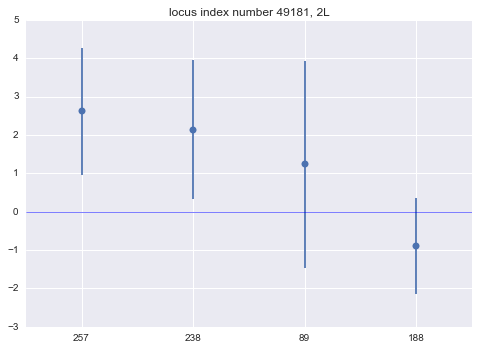

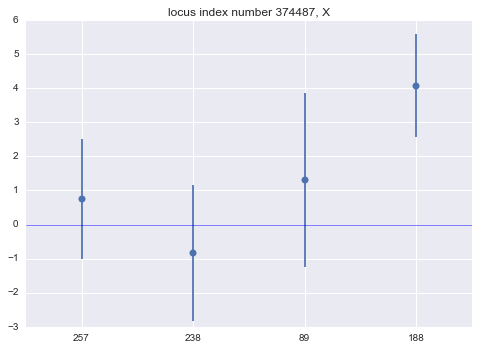

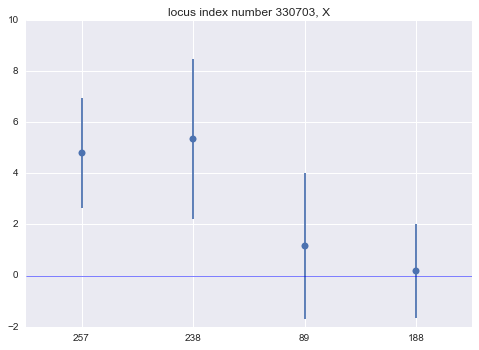

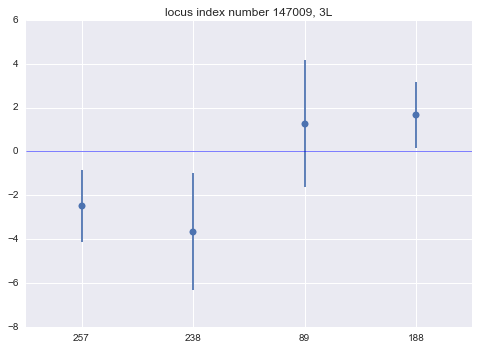

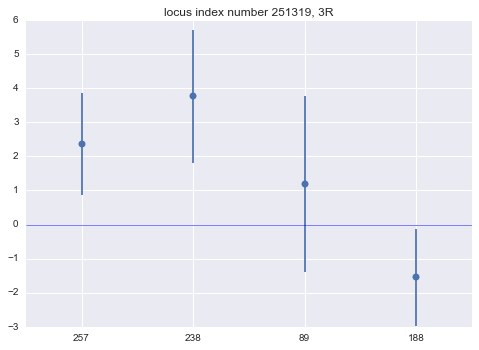

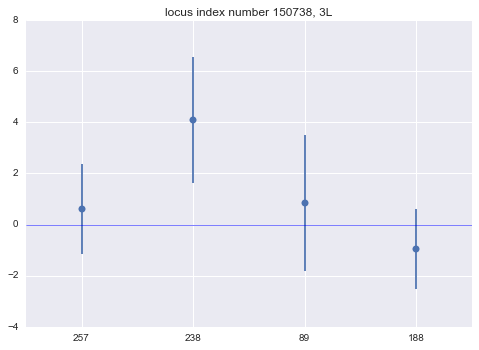

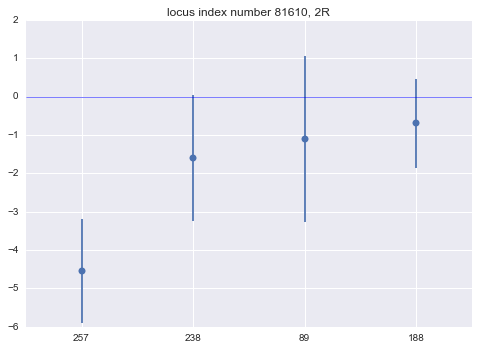

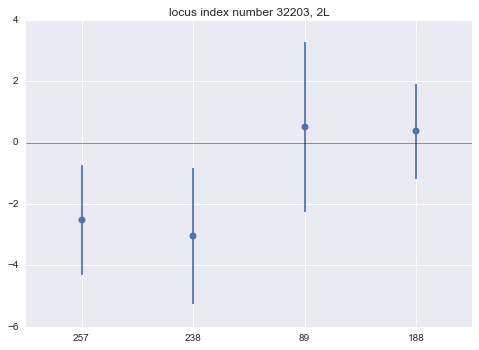

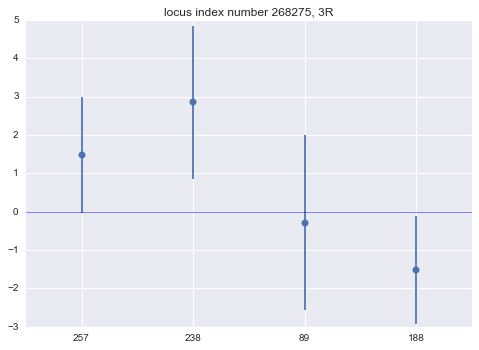

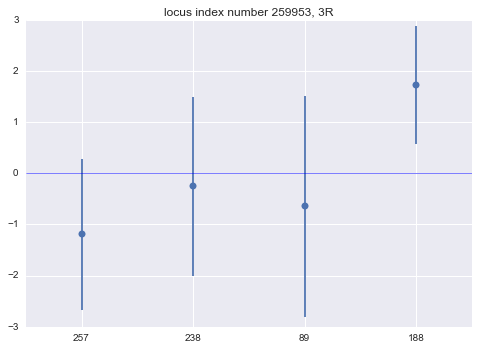

In [12]:
#We plot the mean +- 1.96SE

def plot_graph_at_diff_expressed_locus(tissue, protein, padj, locations_df, log2FC_SE, sample_size=10):
    #Gather a list of random places in the genome of size sample_size
    places_where_sig_interaction=padj[tissue+'_'+ protein][padj[tissue+'_'+ protein]<.05].index.values
    
    #Plot some of these differentially expressed graphs
    for loc in np.random.choice(places_where_sig_interaction, size=sample_size, replace=False):
        val=[log2FC[tissue + '_'+ protein + '_' + line][loc] for line in ["257","238","89","188"]]
        SE=[1.96* log2FC_SE[tissue + '_'+ protein + '_' + line][loc] for line in ["257","238","89","188"]]

        plt.figure()
        ax = plt.subplot(111)
        ax.errorbar(range(4),val, yerr=SE, linestyle='None', fmt='o')
        ax.set_title("locus index number " + str(loc) + ', ' +str(locations_df.loc[loc]["0"]))
        ax.set_xticks(np.arange(4))
        ax.set_xticklabels(["257","238","89","188"])
        ax.set_xlim(left=-.5, right=3.5)
        ax.axhline(y=0,xmin=0,xmax=3.5,linewidth=0.5)
        plt.show()

plot_graph_at_diff_expressed_locus("C","Lam",padj, locations_df, log2FC_SE)

Tim is encouraged from the above plots that nothing is wonky about the statistical model.

## Plot of log2FC across genome 

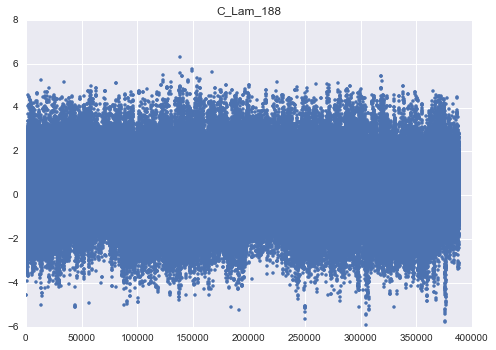

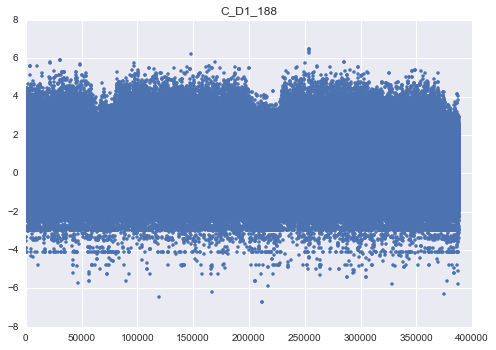

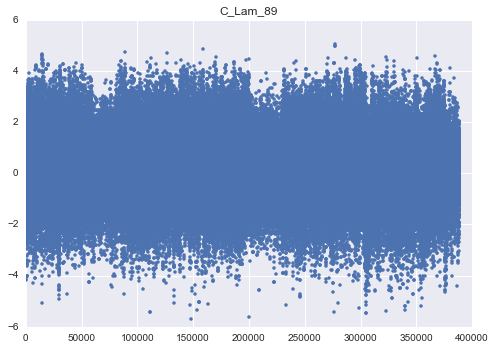

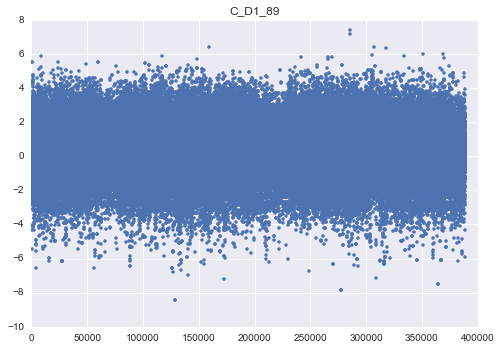

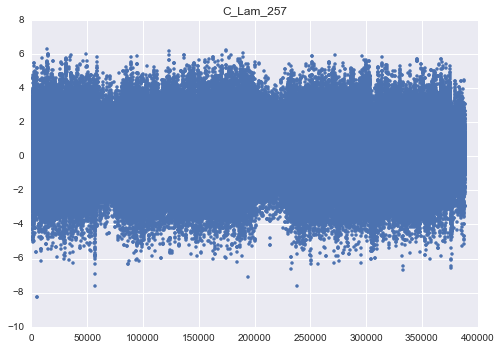

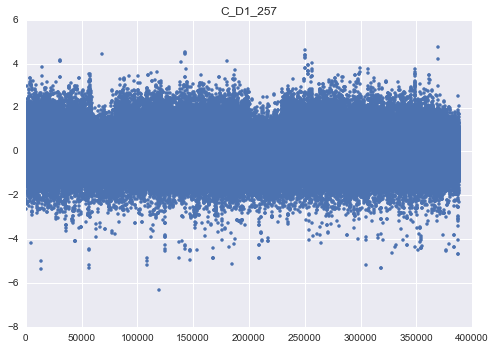

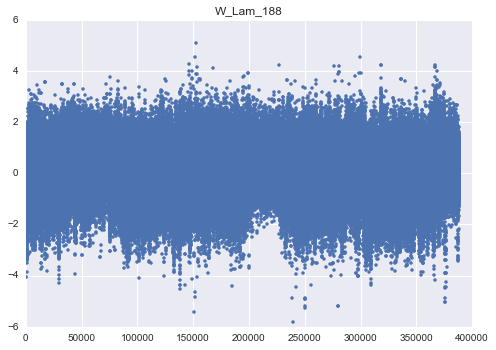

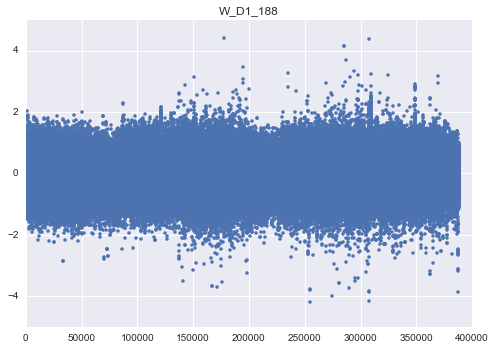

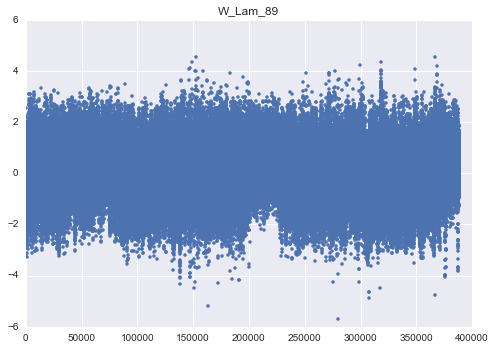

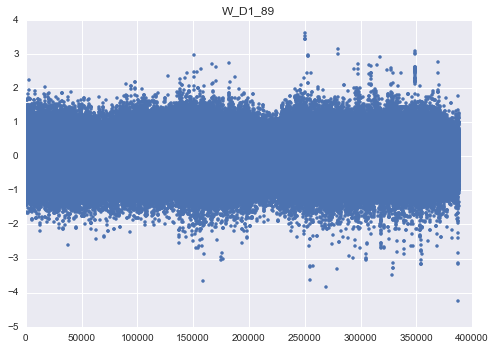

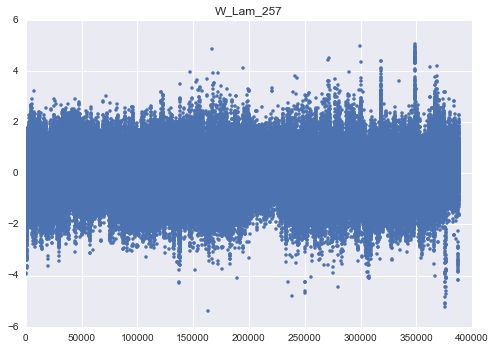

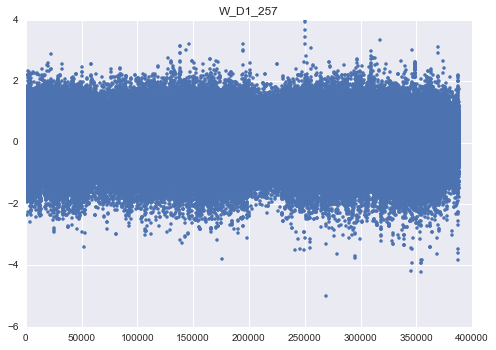

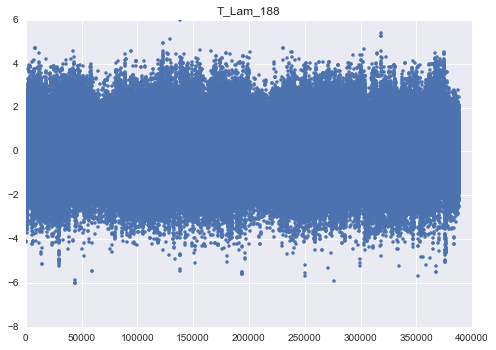

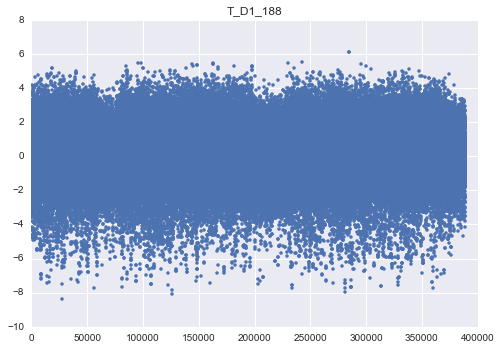

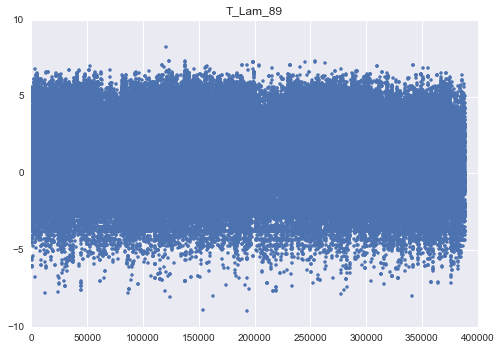

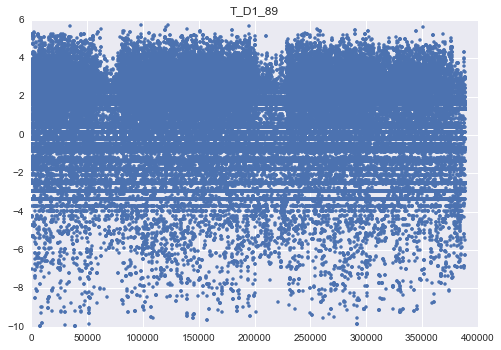

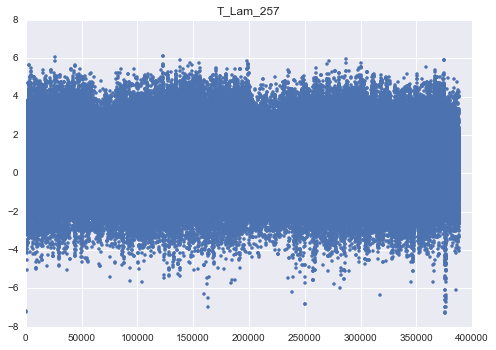

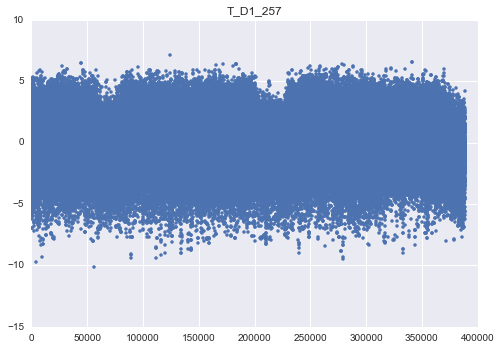

In [15]:
def plot_log2FC(tissue, protein, line):
    f, ax = plt.subplots()
    plt.plot(log2FC[tissue + '_'+ protein + '_' + line][::], '.')
    plt.title(tissue + '_'+ protein + '_' + line)

for tissue in ["C","W", "T"]:
    for line in ["188","89","257"]:
        for protein in ["Lam", "D1"]:
            plot_log2FC(tissue, protein, line)
    

There are spots of little binding (e.g. btw 50000 and 90000, or 200000 and 230000).  There are clearly some issues with T-D1-89, which had already showed up as an outlier on the PCA.

## Manhattan plots of p-values across genome for each protein by line by tissue

In red we lot the Bonferroni p-value cutoff.

In [16]:
lpadjManhatt=[]
lpvalManhatt=[]
for f1 in glob.glob("res*"):
    df_padjManhatt = pd.read_csv(f1).padj
    df_pvalManhatt = pd.read_csv(f1).pvalue
    lpadjManhatt.append(df_padjManhatt)
    lpvalManhatt.append(df_pvalManhatt)
pvalManhatt = pd.concat(lpvalManhatt, axis = 1)
padjManhatt = pd.concat(lpadjManhatt, axis = 1)

pvalManhatt.columns= map(lambda x: x[8:], glob.glob("res*"))
pvalManhatt.head()

padjManhatt.columns= map(lambda x: x[8:], glob.glob("res*"))
padjManhatt.head()

,C_D1_188,C_D1_238,C_D1_257,C_D1_89,C_Lam_188,C_Lam_238,C_Lam_257,C_Lam_89,T_D1_188,T_D1_238,...,T_Lam_257,T_Lam_89,W_D1_188,W_D1_238,W_D1_257,W_D1_89,W_Lam_188,W_Lam_238,W_Lam_257,W_Lam_89
0,NaN,0.995655,0.998638,NaN,NaN,NaN,NaN,NaN,0.999352,NaN,...,NaN,0.856952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.995655,0.998638,NaN,NaN,NaN,NaN,NaN,0.999352,NaN,...,NaN,0.856952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,0.995655,0.998638,NaN,NaN,NaN,NaN,NaN,0.999352,NaN,...,NaN,0.856952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0.995655,0.998638,NaN,NaN,NaN,NaN,NaN,0.999352,NaN,...,NaN,0.856952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,0.995655,0.998638,NaN,NaN,NaN,NaN,NaN,0.999352,NaN,...,NaN,0.856952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


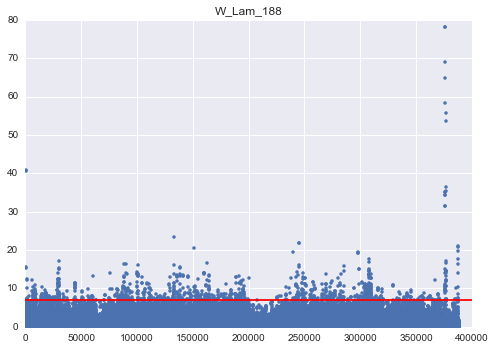

In [8]:
protein="Lam"
line="188"
tissue="W"

f, ax = plt.subplots()
plt.plot(-np.log10(pvalManhatt[tissue + '_'+ protein + '_' + line])[::], '.')
plt.title(tissue + '_'+ protein + '_' + line)
len_data= len(pvalManhatt[tissue + '_'+ protein + '_' + line].dropna())
plt.axhline(y=-np.log10(.05/len_data),xmin=0, xmax=len_data, color="red")

For W-Lam 188, there are clearly some areas with binding very significantly different than Dam.

## Manhattan plots of p-values for intereaction term across genome for each protein by tissue

Areas of where there is differential binding across lines will have high p-values.

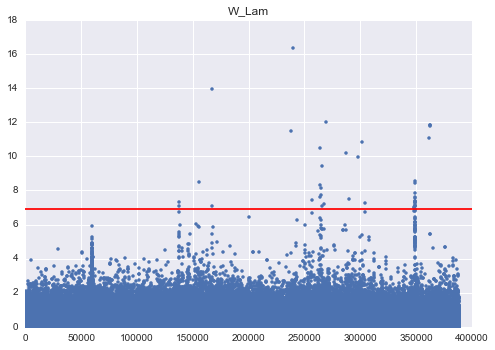

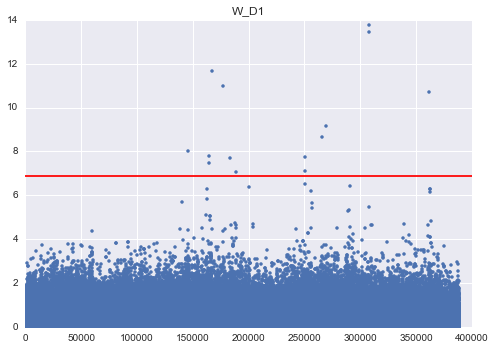

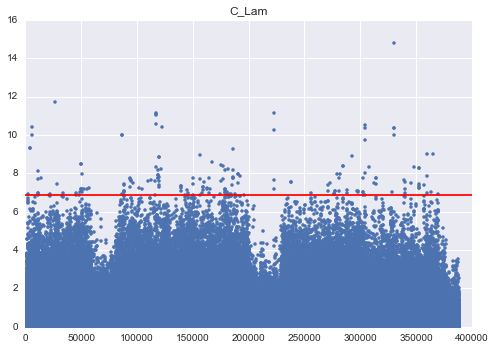

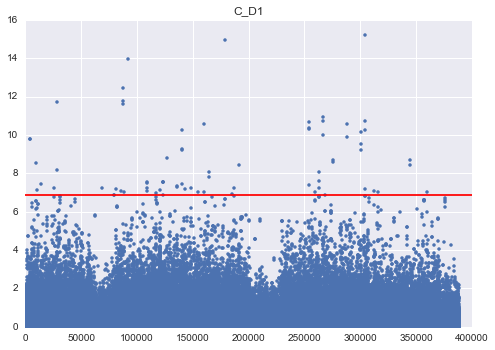

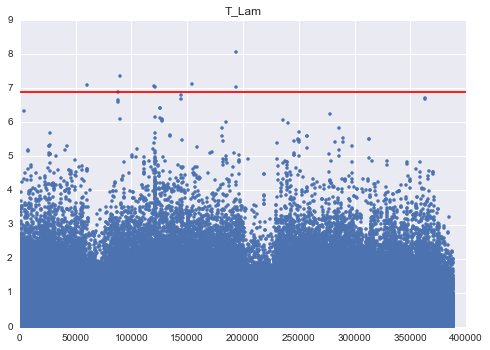

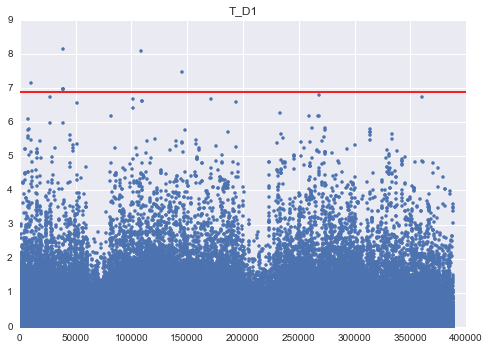

In [11]:
protein="Lam"
tissue="W"
for tissue in ["W","C","T"]:
    for protein in ["Lam", "D1"]:
        f, ax = plt.subplots()
        plt.plot(-np.log10(pval[tissue + '_'+ protein])[::], '.')
        plt.title(tissue + '_'+ protein )
        len_data= len(pval[tissue + '_'+ protein].dropna())
        plt.axhline(y=-np.log10(.05/len_data),xmin=0, xmax=len_data, color="red")
        plt.show()

We look at log2FC at 348694:348780, which corresponds to a peak in W-Lam

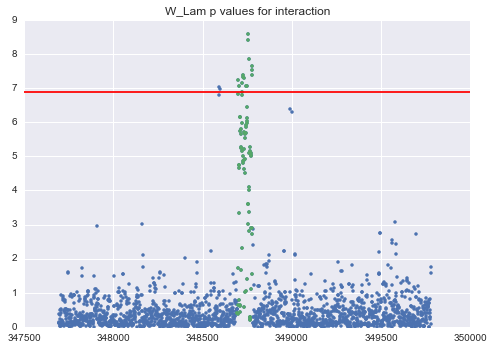

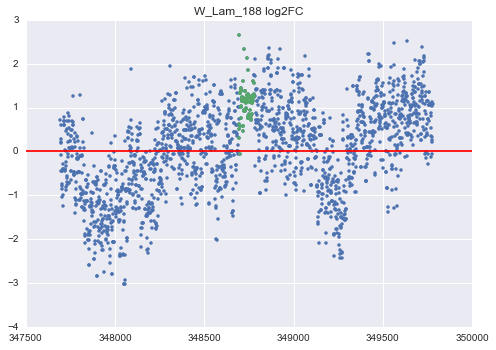

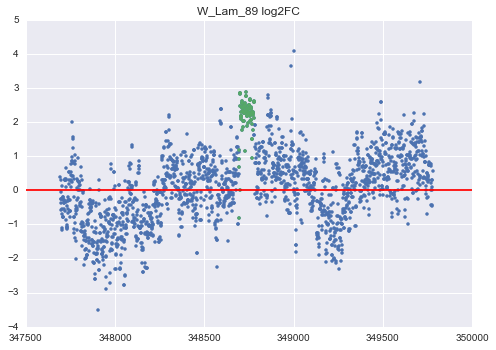

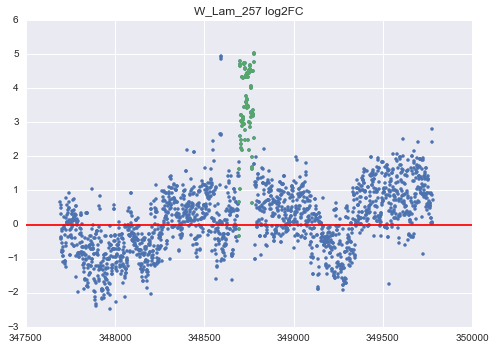

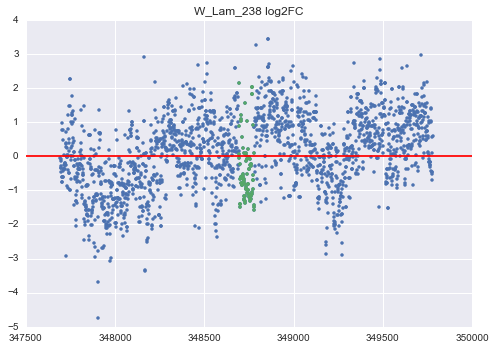

In [23]:
protein="Lam"
tissue="W"

f, ax = plt.subplots()
plt.plot(-np.log10(pval[tissue + '_'+ protein])[347694:349780:], '.')
plt.plot(-np.log10(pval[tissue + '_'+ protein])[348694:348780:], '.')
plt.title(tissue + '_'+ protein + ' p values for interaction' )
len_data= len(pval[tissue + '_'+ protein].dropna())
plt.axhline(y=-np.log10(.05/len_data),xmin=0, xmax=len_data, color="red")
plt.show()


for line in ["188", "89", "257", "238"]:
    f, ax = plt.subplots()
    plt.plot(log2FC[tissue + '_'+ protein + '_' + line][347694:349780:], '.')
    plt.plot(log2FC[tissue + '_'+ protein + '_' + line][348694:348780:], '.')
    plt.title(tissue + '_'+ protein  + '_' + line + ' log2FC')
    len_data= len(log2FC[tissue + '_'+ protein + '_' + line].dropna())
    plt.axhline(y=0,xmin=0, xmax=len_data, color="red")
    plt.show()

The significant peak at 348694-348780 corresponds to X:14039714-14061288.  This is an STE locus.  These STE loci written on the X chromosome are over expressed in males that lack a Y chromosome and are potentially involved in meiotic drive.  There's a suppressor of stellate locus on the Y chromosome that suppresses these particular regions and when you lack a Y chromo or you delete the bulk of the repeats of the Y chromo you get hyper-expression of these stellates, and meiotic abnormalities.

Mechanism:
Could be: suppressor of stellate array places this in the nuclear envelope, which then leads to suppression. 
Or: some other mechanism leads to transcription suppression, and then the fact that it is not transcribed secondarily leads to it being on the periphery of the nucleus.

We looked at the expression of stellate genes to see if they were upregulated in regions that had less Lam binding (in the DESeq file http://localhost:8889/notebooks/20151231_DESeq2_ipython_notebook.ipynb ), but expression was pretty low throughout.  Possibly unlikely that we would see differential expression- if suppressed by DsRNA transcribed from the Y (RNAi), then you would expect there to be little transcription no matter what.  But still interesting that these regions seem to be differentially bound by Lam, because we know that it's a region where there is a known Y chromosome - X chromo interaction.


Next, we zoom in on another peak in W-Lam 

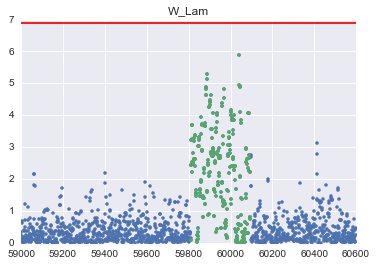

In [46]:
protein="Lam"
tissue="W"

f, ax = plt.subplots()
plt.plot(-np.log10(pval[tissue + '_'+ protein])[59000:60600:], '.')
plt.plot(-np.log10(pval[tissue + '_'+ protein])[59810:60096:], '.')
plt.title(tissue + '_'+ protein )
len_data= len(pval[tissue + '_'+ protein].dropna())
plt.axhline(y=-np.log10(.05/len_data),xmin=0, xmax=len_data, color="red")
plt.show()

In [47]:
#2L:22407610..22505976
print locations_df.loc[59810]
locations_df.loc[60096]

Unnamed: 0       59810
0                   2L
1             22407610
2             22407614
Name: 59810, dtype: object


Unnamed: 0       60096
0                   2L
1             22505972
2             22505976
Name: 60096, dtype: object

We don't see any genes in this region, and this is at the very end of chromsome 2L (near the centromere).

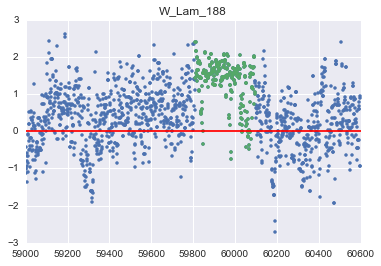

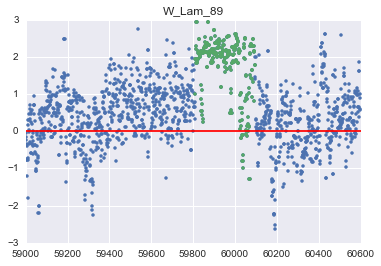

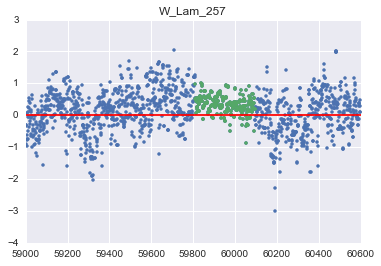

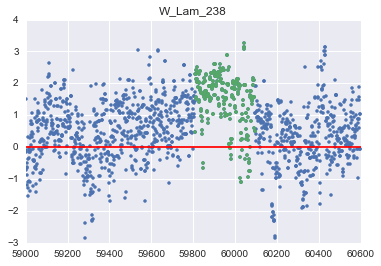

In [49]:
protein="Lam"
tissue="W"
for line in ["188", "89", "257", "238"]:
    f, ax = plt.subplots()
    plt.plot(log2FC[tissue + '_'+ protein + '_' + line][59000:60600:], '.')
    plt.plot(log2FC[tissue + '_'+ protein + '_' + line][59810:60096:], '.')
    plt.title(tissue + '_'+ protein  + '_' + line)
    len_data= len(log2FC[tissue + '_'+ protein + '_' + line].dropna())
    plt.axhline(y=0,xmin=0, xmax=len_data, color="red")
    plt.show()

Now we zoom in on a peak in T -Lam

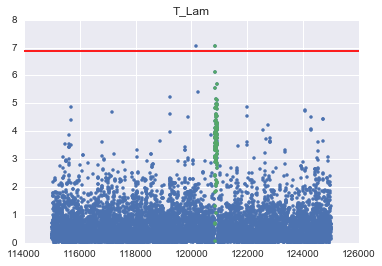

In [28]:
protein="Lam"
tissue="T"

f, ax = plt.subplots()
plt.plot(-np.log10(pval[tissue + '_'+ protein])[115000:125000:], '.')
plt.plot(-np.log10(pval[tissue + '_'+ protein])[120830:120930:], '.')
#plt.plot(-np.log10(pval[tissue + '_'+ protein])[::], '.')
plt.title(tissue + '_'+ protein )
len_data= len(pval[tissue + '_'+ protein].dropna())
plt.axhline(y=-np.log10(.05/len_data),xmin=0, xmax=len_data, color="red")
plt.show()

In [29]:
print locations_df.loc[120830]
print locations_df.loc[120930]

Unnamed: 0      120830
0                   2R
1             19727424
2             19727428
Name: 120830, dtype: object
Unnamed: 0      120930
0                   2R
1             19765119
2             19765123
Name: 120930, dtype: object


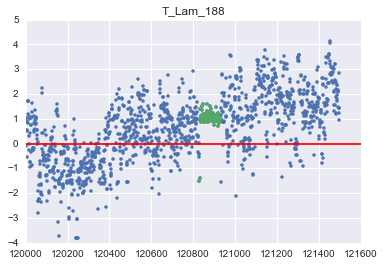

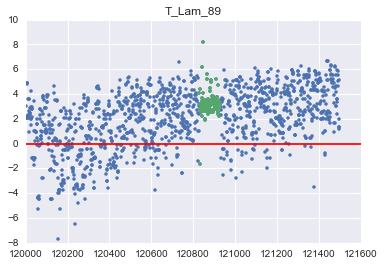

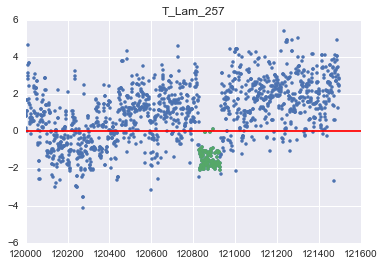

In [27]:
protein="Lam"
tissue="T"
for line in ["188", "89", "257"]:
    f, ax = plt.subplots()
    plt.plot(log2FC[tissue + '_'+ protein + '_' + line][120000:121500:], '.')
    plt.plot(log2FC[tissue + '_'+ protein + '_' + line][120830:120930:], '.')
    plt.title(tissue + '_'+ protein  + '_' + line)
    len_data= len(log2FC[tissue + '_'+ protein + '_' + line].dropna())
    plt.axhline(y=0,xmin=0, xmax=len_data, color="red")
    plt.show()

This corresponds to 5S rRNA (ribosomal RNA) (lots of repeats) (see flybase 2R:19,727,428..19,765,123)  http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3278907/ .  These are present in an array of tandem repeats.

For rRNA locus, there's 18S, 28S and 5S.  18S and 28S located on X and Y, but 5S is not.

Very likely correlation between 18S, 28S and 5S because of requirements to make functional ribosome.  

Both the stellate locus and 5S locus are potentially regions where there is highly variable repeats on Y chromosome associated with region that is outside of the Y.  

The rDNA locus on the Y is highly variable (e.g. 18S and 28S) (like 3 or 4 fold length difference).  The bobbed mutant leads to this variation.  Transcription with the rDNA locus correlated with the size of the rDNA locus.  If lots of 18S and 28S, then you should get lots of 5S (and vice versa).  Autosomal but Y related repeats seem to be the strongest signal of variability.

If your suppressor in stellate region varies in size, you may also get variability in binding in the stellate region.

5s rRNA is a very highly transcribed region.  But of course you don't get protein from it.

Variability in rDNA copy number (Bernardo Lemos)

Zhou Jun paper

Worth looking up to see if rRNA is AT-rich.  

Check out papers e-mailed by Tim 06/16/16

It seems clear that there are specific regions that are affected.  There's definitely spatial structure to the data.  Certain regions that show differential binding among lines.  
Take all those that show differential bidnign for D1 and pull up AT content

go to ftp://ftp.flybase.net/genomes/Drosophila_melanogaster/current/fasta/ 
look at whole chromosome to get AT content.  compare with regions bound by D1.


## Automated method

In the below function, if there is a non-significant p-value, we immediately end the "region of interest"

[24, 75, 36, 24]
[120856, 120933, 149529, 355387]


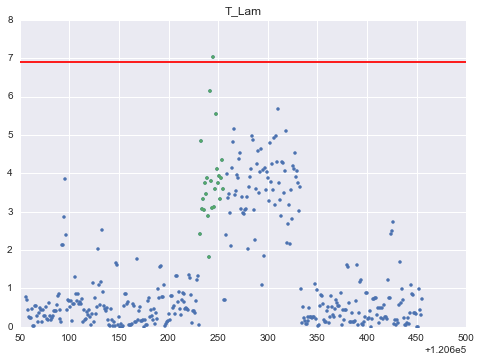

2R : 19729652 .. 19738546


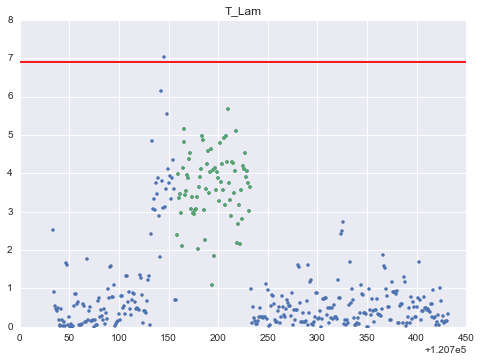

2R : 19738908 .. 19766238


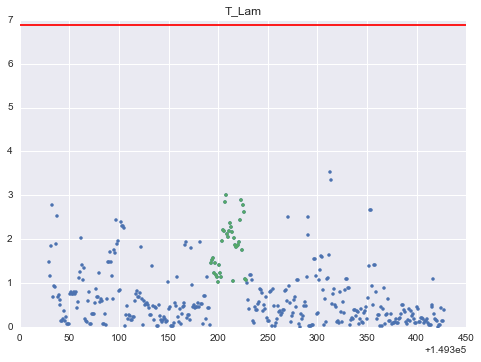

3L : 3899575 .. 3901673


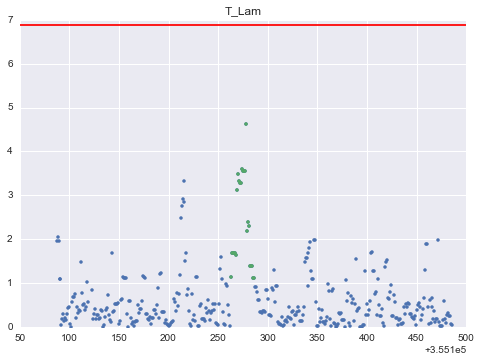

X : 16310986 .. 16312078


In [24]:
#find contiguous bits of significant DNA.  Keep all those greater than MIN_LENGTH

def plot_sig_bits_of_DNA_and_location(tissue, protein, MIN_LENGTH=25, P_VAL=.1):
    sig_length=[]
    indices_of_sig_length=[]
    counter = 0
    for i,ele in enumerate(pval[tissue + '_'+ protein] <P_VAL):
        if ele:
            counter+=1
        else:
            if counter>MIN_LENGTH:
                sig_length.append(counter)
                indices_of_sig_length.append(i)
            counter=0


    print sig_length
    print indices_of_sig_length
    
    for ind, len_ind in zip(indices_of_sig_length, sig_length):
        f, ax = plt.subplots()
        plt.plot(-np.log10(pval[tissue + '_'+ protein])[ind - 200 :ind + 200:], '.')
        plt.plot(-np.log10(pval[tissue + '_'+ protein])[ind - len_ind:ind:], '.')
        #plt.plot(-np.log10(pval[tissue + '_'+ protein])[::], '.')
        plt.title(tissue + '_'+ protein )
        len_data= len(pval[tissue + '_'+ protein].dropna())
        plt.axhline(y=-np.log10(.05/len_data),xmin=0, xmax=len_data, color="red")
        plt.show()
        print locations_df.loc[ind - len_ind]['0'], ":",locations_df.loc[ind - len_ind]['1'], '..', locations_df.loc[ind]['2']

plot_sig_bits_of_DNA_and_location("T", "Lam", MIN_LENGTH=20)


We notice above that the 5srRNA region got cut into two, because there was some non-significant p-value.  We write a new function that allows for some number of non-significant p-values in a significant region.

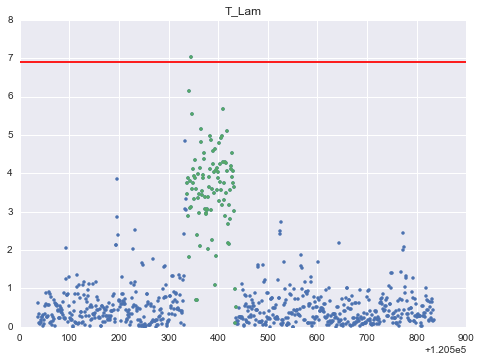

2R:19731499..19770695


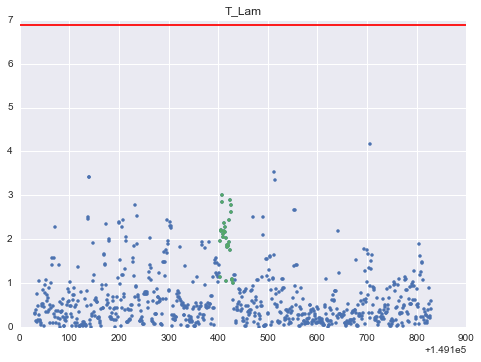

3L:3900073..3901754


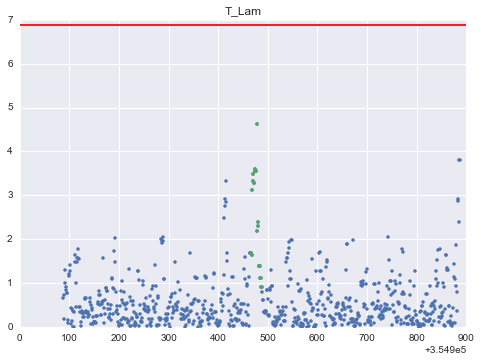

X:16311124..16312084


In [47]:
def plot_sig_bits_of_DNA_and_location_blank_spaces(tissue, protein, MIN_LENGTH=20, P_VAL=.05, MAX_BLANK_SPACES_IN_A_ROW=3):
    sig_length=[]
    indices_of_sig_length=[]
    counter = 0
    blank_spaces=0
    for i,ele in enumerate(pval[tissue + '_'+ protein] <P_VAL):
        if ele:
            counter+=1
            blank_spaces=0
        else:
            blank_spaces+=1
            if blank_spaces > MAX_BLANK_SPACES_IN_A_ROW:
                if counter>MIN_LENGTH:
                    sig_length.append(counter)
                    indices_of_sig_length.append(i)
                counter = 0
                blank_spaces=0

    
    for ind, len_ind in zip(indices_of_sig_length, sig_length):
        f, ax = plt.subplots()
        plt.plot(-np.log10(pval[tissue + '_'+ protein])[ind - 400 :ind + 400:], '.')
        plt.plot(-np.log10(pval[tissue + '_'+ protein])[ind - len_ind:ind:], '.')
        #plt.plot(-np.log10(pval[tissue + '_'+ protein])[::], '.')
        plt.title(tissue + '_'+ protein )
        len_data= len(pval[tissue + '_'+ protein].dropna())
        plt.axhline(y=-np.log10(.05/len_data),xmin=0, xmax=len_data, color="red")
        plt.show()
        print ''.join(map(str,(locations_df.loc[ind - len_ind]['0'], ":",locations_df.loc[ind - len_ind]['1'], '..', locations_df.loc[ind]['2'])))

plot_sig_bits_of_DNA_and_location_blank_spaces("T", "Lam", MIN_LENGTH=20)
#plot_sig_bits_of_DNA_and_location_blank_spaces("T", "Lam", MIN_LENGTH=15, P_VAL=.03, MAX_BLANK_SPACES_IN_A_ROW=3)






For min_length = 25, we get:
For T-Lam, we get 5S-rRNA, and ubiquitin 63-E (involved in male meiosis 1 http://flybase.org/reports/FBgn0003943.html )

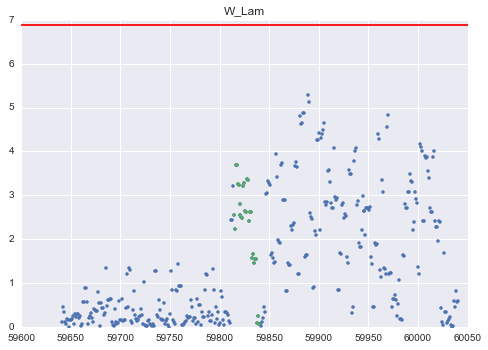

2L:22409449..22418094


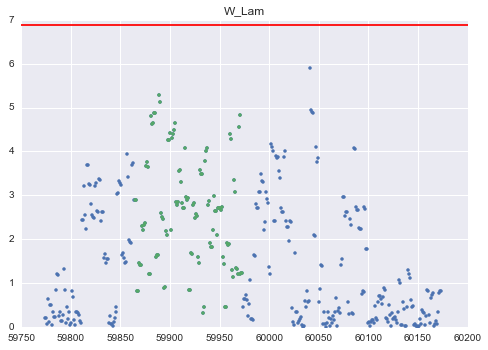

2L:22426580..22464415


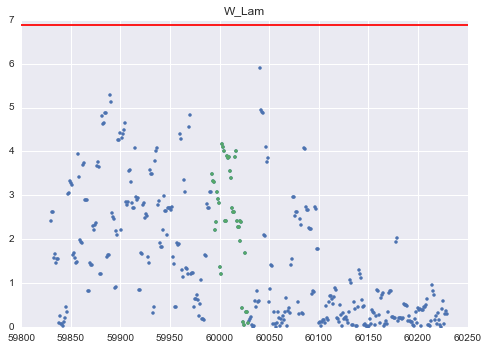

2L:22471558..22484176


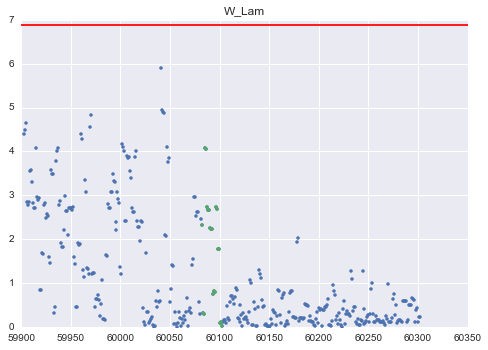

2L:22501490..22508017


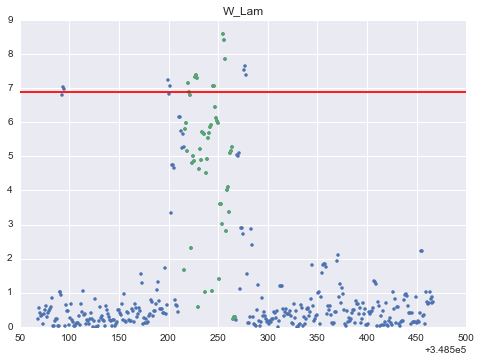

X:14049763..14058878


In [46]:
#find contiguous bits of significant DNA.  Keep all those greater than MIN_LENGTH

plot_sig_bits_of_DNA_and_location_blank_spaces("W", "Lam")

for W-LAM

2L:22408623..22418021 : near centromere 
X:14049748..14058768 : stellate

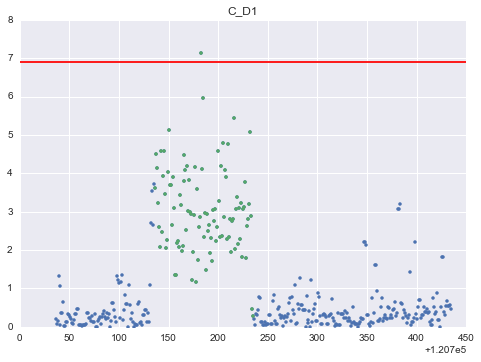

2R:19731133..19770695


In [35]:
plot_sig_bits_of_DNA_and_location_blank_spaces("C", "D1")


For C-D1, second hit for 5s rRNA, (the first hit was for T-Lam)

Now we plot the two log2FC graphs to compare the 5s rRNA in T-LAM and C_D1

231
232
233
234
235
236


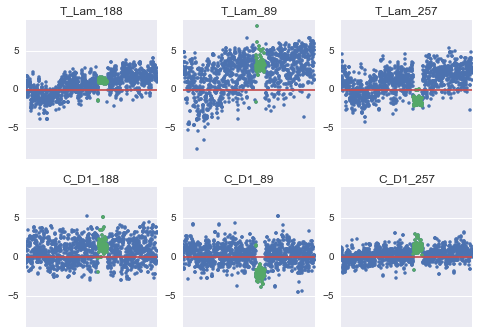

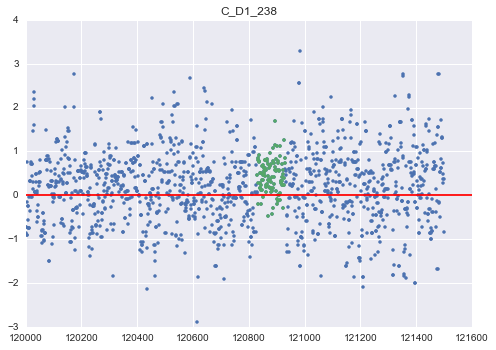

In [67]:
protein="Lam"
tissue="T"
fig = plt.figure()
for i,line in enumerate(["188", "89", "257"]):
    #f, ax = plt.subplots()
    subplot_num=int('23'+str(i+1))
    print subplot_num
    ax = fig.add_subplot(subplot_num)
    #plt.plot(log2FC[tissue + '_'+ protein + '_' + line][120000:121500:], '.')
    ax.plot(log2FC[tissue + '_'+ protein + '_' + line][120000:121500:], '.')
    ax.plot(log2FC[tissue + '_'+ protein + '_' + line][120830:120930:], '.')
    #plt.plot(log2FC[tissue + '_'+ protein + '_' + line][120830:120930:], '.')
    ax.set_title(tissue + '_'+ protein  + '_' + line)
    #plt.title(tissue + '_'+ protein  + '_' + line)
    len_data= len(log2FC[tissue + '_'+ protein + '_' + line].dropna())
    ax.set_xticks([])
    ax.set_ylim([-9,9])
    ax.plot([120000, 121500],[0, 0])
    #plt.axhline(y=0,xmin=0, xmax=len_data, color="red")
    #plt.show()
    
protein="D1"
tissue="C"
for i,line in enumerate(["188", "89", "257"]):
    #f, ax = plt.subplots()
    subplot_num=int('23'+str(i+4))
    print subplot_num
    ax = fig.add_subplot(subplot_num)
    #plt.plot(log2FC[tissue + '_'+ protein + '_' + line][120000:121500:], '.')
    ax.plot(log2FC[tissue + '_'+ protein + '_' + line][120000:121500:], '.')
    ax.plot(log2FC[tissue + '_'+ protein + '_' + line][120830:120930:], '.')
    #plt.plot(log2FC[tissue + '_'+ protein + '_' + line][120830:120930:], '.')
    ax.set_title(tissue + '_'+ protein  + '_' + line)
    #plt.title(tissue + '_'+ protein  + '_' + line)
    len_data= len(log2FC[tissue + '_'+ protein + '_' + line].dropna())
    ax.set_xticks([])
    ax.set_ylim([-9,9])
    ax.plot([120000, 121500],[0, 0])
    
plt.figure()
protein="D1"
tissue="C"
for line in ["238"]:
    f, ax = plt.subplots()
    plt.plot(log2FC[tissue + '_'+ protein + '_' + line][120000:121500:], '.')
    plt.plot(log2FC[tissue + '_'+ protein + '_' + line][120830:120930:], '.')
    plt.title(tissue + '_'+ protein  + '_' + line)
    len_data= len(log2FC[tissue + '_'+ protein + '_' + line].dropna())
    plt.axhline(y=0,xmin=0, xmax=len_data, color="red")
    plt.show()

Does not always act in opposite direction.

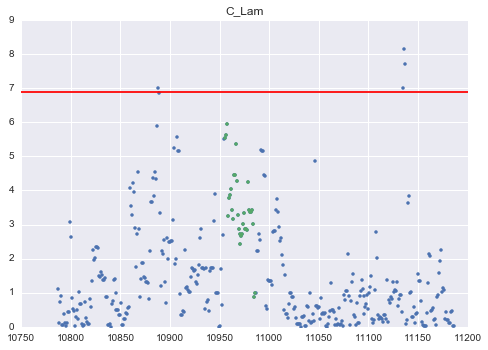

2L:3637906..3642444


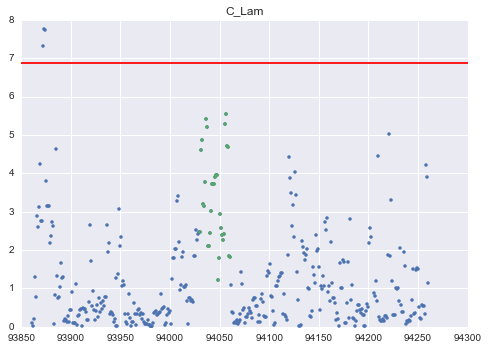

2R:10131836..10135867


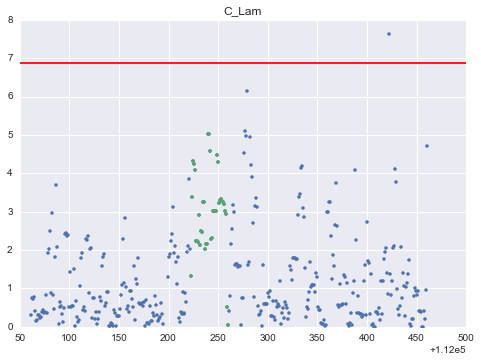

2R:16574141..16579344


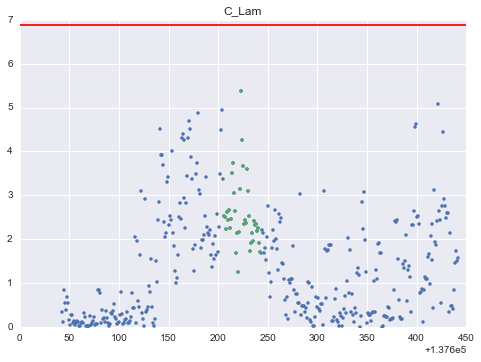

3L:10535..16176


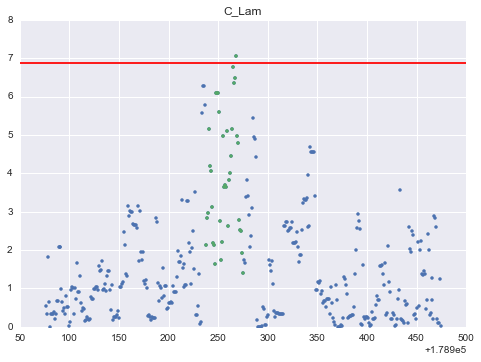

3L:15233185..15237860


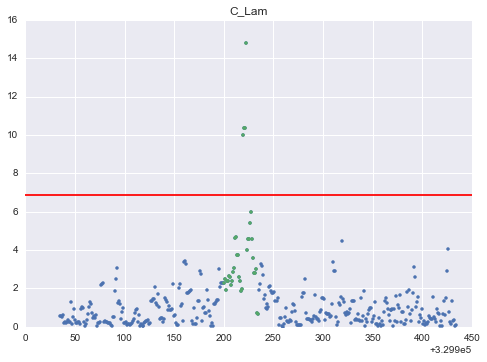

X:7312397..7317128


In [39]:
plot_sig_bits_of_DNA_and_location_blank_spaces("C", "Lam", MIN_LENGTH=30, P_VAL=.01)

For C_Lam, you get: 
    nothing, 
    α Spectrin (http://flybase.org/reports/FBgn0250789.html)
    mauve
    ...
    
But we don't really trust C-Lam188 as a sample..., we think there might be mislabeling.  ONE WAY TO CHECK THAT IS TO SEE IF C-LAM 188 CONSTANTLY DIFFERENT FROM THE OTHER TWO.
    

## P-value as a binary

We creat a binary: either p-value is significant or not.  We plot in a restricted range.  There are definitely areas where you have significant binding.

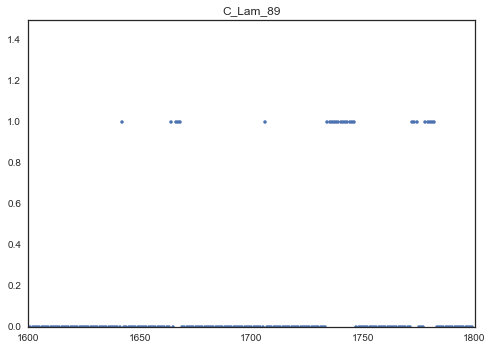

In [153]:
protein="Lam"
line="89"
tissue="C"

f, ax = plt.subplots()
plt.plot((pvalManhatt[tissue + '_'+ protein + '_' + line] <.1)[1600:1800], '.')
plt.ylim([0,1.5])
plt.title(tissue + '_'+ protein + '_' + line)

Let's now plot a histogram of the length of these significant region for any region greater than 1.  We see for this that the length of the significant tracts much longer for Lam than D1.  We are counting NAs as non-significant.

15
130


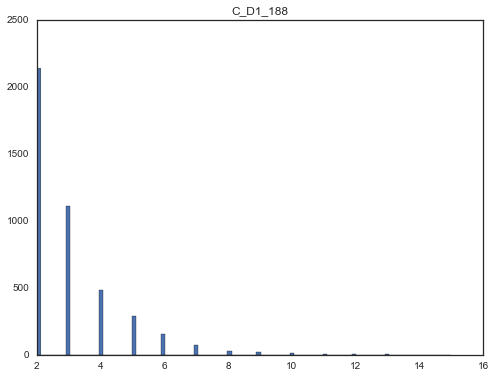

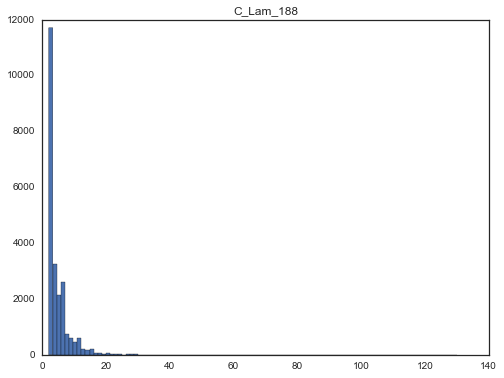

In [352]:
def plot_histogram_length_significant_spots(protein, tissue, line):
    sig_length=[]
    indices_of_sig_length=[]
    counter = 0
    for i,ele in enumerate(pvalManhatt[tissue + '_'+ protein + '_' + line] <.1):
        if ele:
            counter+=1
        else:
            if counter>1:
                sig_length.append(counter)
                indices_of_sig_length.append(i)
            counter=0

    plt.figure(figsize=[8,6])
    _=plt.hist(sig_length, bins=100)
    plt.title(tissue + '_'+ protein + '_' + line)

    print max(sig_length)
    
plot_histogram_length_significant_spots("D1", "C", "188")
plot_histogram_length_significant_spots("Lam", "C", "188")

Here I allow there to be some flexibility by allowing maximum 4 non-significant p-vals to get a pass.

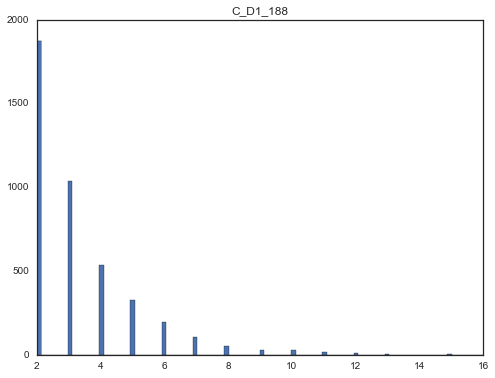

16


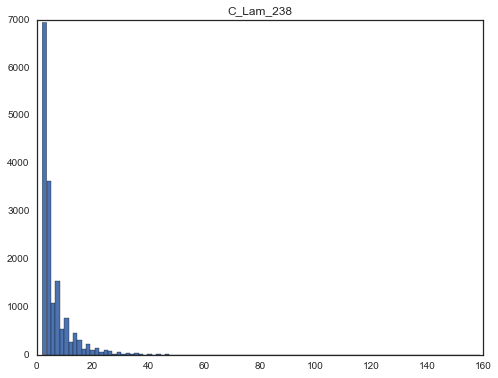

159


In [378]:
def plot_histogram_length_significant_spots_flexible(protein, tissue, line):
    sig_length=[]
    indices_of_sig_length=[]
    blank_spaces=0
    counter = 0
    for i,ele in enumerate(pvalManhatt[tissue + '_'+ protein + '_' + line] <.1):
        if ele:
            counter+=1
        else:
            blank_spaces+=1
            if blank_spaces > 4:
                if counter > 1:
                    sig_length.append(counter)
                    indices_of_sig_length.append(i)
                    #print i
                blank_spaces = 0
                counter=0

    plt.figure(figsize=[8,6])
    _=plt.hist(sig_length, bins=100)
    plt.title(tissue + '_'+ protein + '_' + line)
    plt.show()

    print max(sig_length)
    
plot_histogram_length_significant_spots_flexible("D1", "C", "188")
plot_histogram_length_significant_spots_flexible("Lam", "C", "238")

In C Lam 188, the region with 134 significant p-values in a row is on chromosome 3L.

In [364]:
locations_df.loc[137875-134]

Unnamed: 0    137741
0                 3L
1                620
2                624
Name: 137741, dtype: object

Let's plot the p-values in that region

409


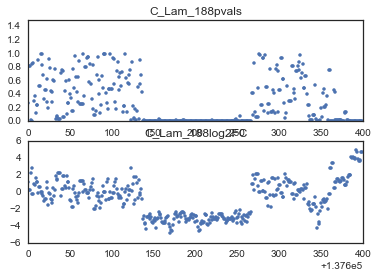

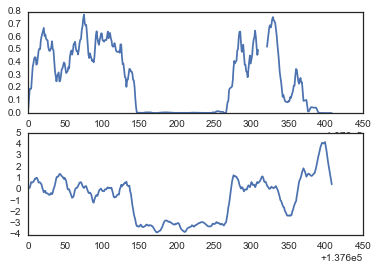

In [423]:
protein="Lam"
line="188"
tissue="C"

f, ax = plt.subplots(2)
ax[0].plot(pvalManhatt[tissue + '_'+ protein + '_' + line] [137600:138000], '.')
ax[0].set_ylim([0,1.5])
ax[0].set_title(tissue + '_'+ protein + '_' + line + "pvals")

ax[1].plot(log2FC[tissue + '_'+ protein + '_' + line] [137600:138000], '.')
#plt.ylim([0,1.5])
plt.title(tissue + '_'+ protein + '_' + line+ "log2FC")


f, ax = plt.subplots(2)
# make a gaussian window
window = signal.gaussian(10, 100)
ga = signal.convolve(pvalManhatt[tissue + '_'+ protein + '_' + line][137600:138000], window/window.sum())
print len(ga)

ax[0].plot(range(137600,137600+len(ga)), ga)
ga = signal.convolve(log2FC[tissue + '_'+ protein + '_' + line][137600:138000], window/window.sum())
ax[1].plot(range(137600,137600+len(ga)), ga)

Let's see what that region looks like over other line protein tissue combos

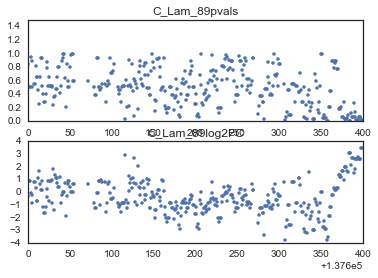

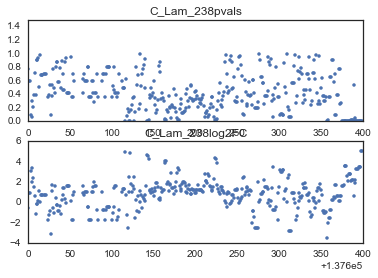

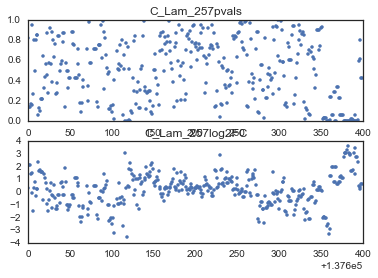

In [394]:
protein="Lam"
line="89"
tissue="C"

f, ax = plt.subplots(2)
ax[0].plot(pvalManhatt[tissue + '_'+ protein + '_' + line] [137600:138000], '.')
ax[0].set_ylim([0,1.5])
ax[0].set_title(tissue + '_'+ protein + '_' + line + "pvals")

ax[1].plot(log2FC[tissue + '_'+ protein + '_' + line] [137600:138000], '.')
#plt.ylim([0,1.5])
plt.title(tissue + '_'+ protein + '_' + line+ "log2FC")

protein="Lam"
line="238"
tissue="C"

f, ax = plt.subplots(2)
ax[0].plot(pvalManhatt[tissue + '_'+ protein + '_' + line] [137600:138000], '.')
ax[0].set_ylim([0,1.5])
ax[0].set_title(tissue + '_'+ protein + '_' + line + "pvals")

ax[1].plot(log2FC[tissue + '_'+ protein + '_' + line] [137600:138000], '.')
#plt.ylim([0,1.5])
plt.title(tissue + '_'+ protein + '_' + line+ "log2FC")

protein="Lam"
line="257"
tissue="C"

f, ax = plt.subplots(2)
ax[0].plot(pvalManhatt[tissue + '_'+ protein + '_' + line] [137600:138000], '.')
ax[0].set_title(tissue + '_'+ protein + '_' + line + "pvals")

ax[1].plot(log2FC[tissue + '_'+ protein + '_' + line] [137600:138000], '.')
#plt.ylim([0,1.5])
plt.title(tissue + '_'+ protein + '_' + line+ "log2FC")

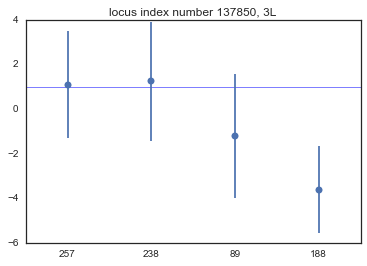

In [393]:
protein="Lam"
tissue="C"
loc=137850

val=[log2FC[tissue + '_'+ protein + '_' + line][loc] for line in ["257","238","89","188"]]
SE=[1.96* log2FC_SE[tissue + '_'+ protein + '_' + line][loc] for line in ["257","238","89","188"]]

plt.figure()
ax = plt.subplot(111)
ax.errorbar(range(4),val, yerr=SE, linestyle='None', fmt='o')
ax.set_title("locus index number " + str(loc) + ', ' +str(locations_df.loc[loc]["0"]))
ax.set_xticks(np.arange(4))
ax.set_xticklabels(["257","238","89","188"])
ax.set_xlim(left=-.5, right=3.5)
ax.axhline(y=1,xmin=0,xmax=3.5,linewidth=0.5,zorder=0)
plt.show()

In C Lam 257, the region with 127 significant p-values in a row is on chromosome 2R (it is a different region!)

In [368]:
locations_df.loc[89115-127]

Unnamed: 0      88981
0                  2R
1             8443994
2             8443998
Name: 88981, dtype: object

In C Lam 238, the region with 159 significant p-values in a row is on chromosome 2L (it is a different region!)

In [372]:
locations_df.loc[15272-159]


Unnamed: 0      15113
0                  2L
1             5123749
2             5123753
Name: 15113, dtype: object

Now let's get an idea of how dispersed regions of significance are (region of significant is 5 or more p-values <.1).  The average distance of D1 C 188 is 131, and for Lam is 17.  We dropped NAs.  So things look very dispersed on average.

The notation is reversed because I took plot_histogram_length_significant_spots_flexible and flipped the sign on pvalManhatt[tissue + '_'+ protein + '_' + line].dropna() <.1 to get the length of the non-significant regions.

Be careful because distance between adjacent sites heterogeneous across genome.

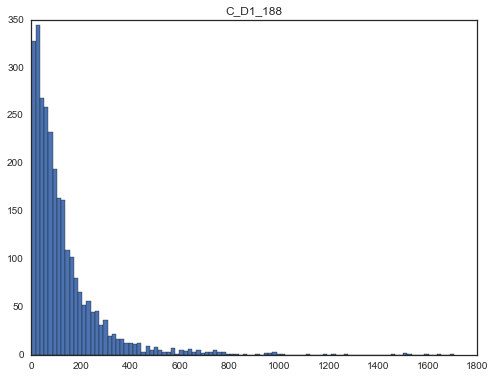

1705 max
131.430604982 mean


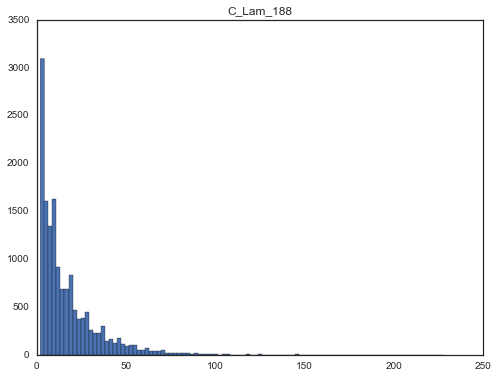

228 max
17.252233768 mean


In [431]:
def plot_histogram_length_NONsignificant_spots_flexible(protein, tissue, line):
    sig_length=[]
    indices_of_sig_length=[]
    blank_spaces=0
    counter = 0
    for i,ele in enumerate(pvalManhatt[tissue + '_'+ protein + '_' + line].dropna() >.1):
        if ele:
            counter+=1
        else:
            blank_spaces+=1
            if blank_spaces > 5:
                if counter > 1:
                    sig_length.append(counter)
                    indices_of_sig_length.append(i)
                    #print i
                blank_spaces = 0
                counter=0

    plt.figure(figsize=[8,6])
    _=plt.hist(sig_length, bins=100)
    plt.title(tissue + '_'+ protein + '_' + line)
    plt.show()

    print max(sig_length), "max"
    print np.mean(sig_length), "mean"
    
plot_histogram_length_NONsignificant_spots_flexible("D1", "C", "188")
plot_histogram_length_NONsignificant_spots_flexible("Lam", "C", "188")

## Distribution of p-values across different datasets

now let's look at the distribution of p-values for these line by protein datasets.  in the aggregate, there is signal of significant binding.

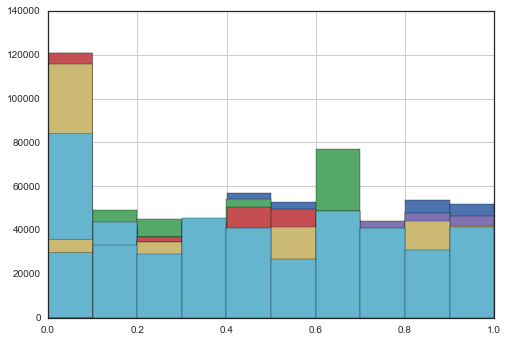

In [99]:
for protein in ["Lam", "D1"]:
    for line in ["89", "188", "257"]:
        for tissue in ["C","T"]:
            pvalManhatt[tissue + '_'+ protein + '_' + line].hist()

let's look at the non-stacked version of the above plot.  we see that all protein by line combos don't show all that significant p-values.

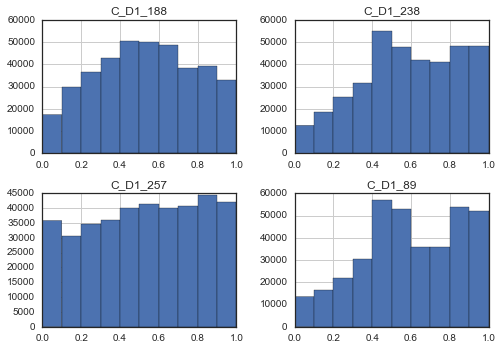

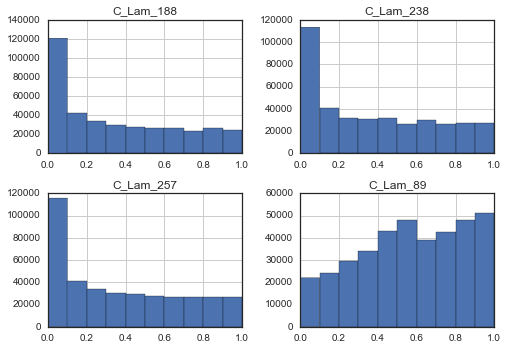

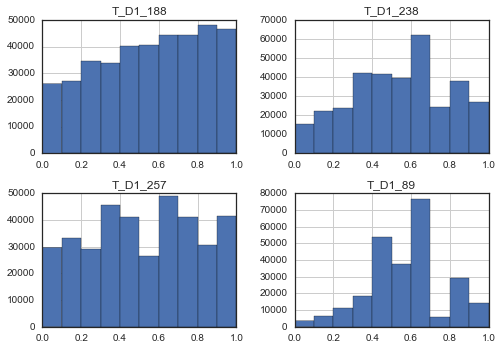

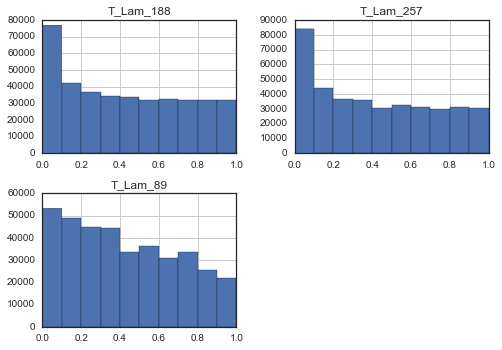

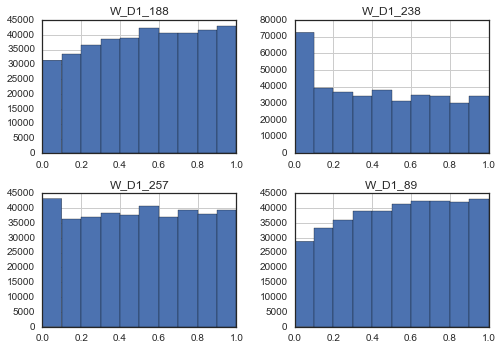

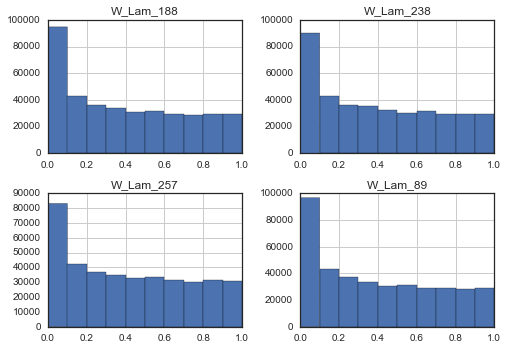

In [120]:
#C D1
_=plt.figure()
pvalManhatt.ix[:,:4].hist()
plt.show()

#C Lam
_=plt.figure()
pvalManhatt.ix[:,4:8].hist()
plt.show()

_=plt.figure()
pvalManhatt.ix[:,8:12].hist()
plt.show()

_=plt.figure()
pvalManhatt.ix[:,12:15].hist()
plt.show()

_=plt.figure()
pvalManhatt.ix[:,15:19].hist()
plt.show()

_=plt.figure()
pvalManhatt.ix[:,19:].hist()
plt.show()

The W-Lam case is interesting, because it did not show a whole lot of differential binding by line, but it clearly is binding.  In our correlation plot, we saw that W-Lams were most correlated to each other.  So not a whole lot of differential binding, but strong binding nonetheless.

W-D1 238 and 257 show some signal of binding.

T-D1 basically shows nothing significant for anything.

C-Lam 89 very different signal from the other C-Lams.  Remember, strongest differential binding was for C-Lams. (I wonder if we would see this pattern if we removed 89, because 89 doesn't seem to differentially bind to anything, but then again there was a high correlation in log2FC across C-Lams).

A lot of this could have to do with the replicate to replicate variability.  The more variable replicates are the less significant the p-value will be.  So there might be a lot of variability.  CHECK TO SEE IF ONE OF THE C-LAM-89 REPLICATES IS A STRONG OUTLIER.  LOOK AT THE DISTRIBUTION OF SE, BECAUSE IT MIGHT BE MUCH BIGGER IN THE C-LAM-89.  


C-D1 also doesn't show much.

## Calculating ACF

We calculate the ACF of the log2fold change for each line by protein tissue combination.  There is pretty strong autocorrelation, but only for the Lams.

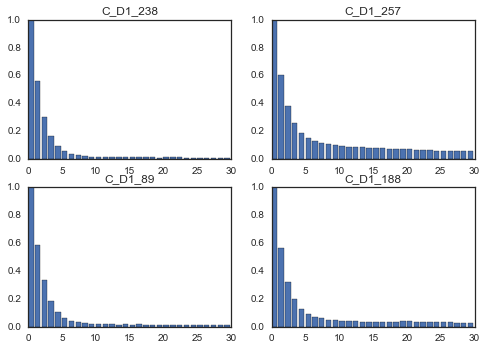

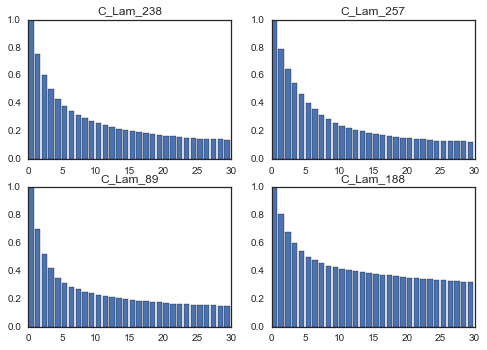

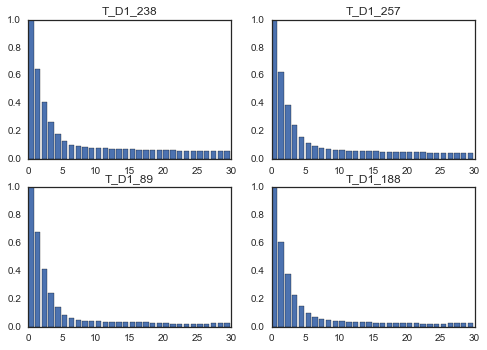

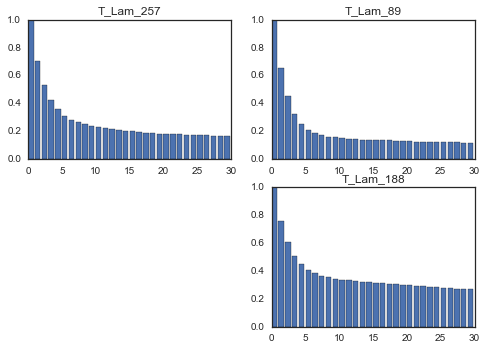

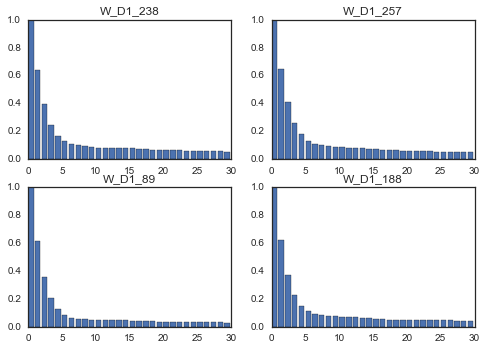

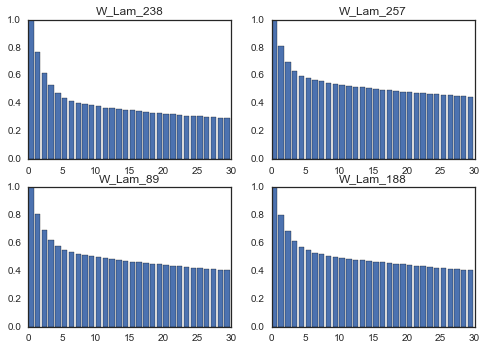

In [173]:
LAGS = 30
fig = plt.figure()
for i,col in enumerate(log2FC.columns[:4]):
    subplot_num='22'+str(i)
    fig.add_subplot(subplot_num)
    _=plt.bar(range(LAGS),[log2FC[col].autocorr(i) for i in range(LAGS)])
    plt.title(col)
    
fig = plt.figure()
for i,col in enumerate(log2FC.columns[4:8]):
    subplot_num='22'+str(i)
    fig.add_subplot(subplot_num)
    _=plt.bar(range(LAGS),[log2FC[col].autocorr(i) for i in range(LAGS)])
    plt.title(col)

    
fig = plt.figure()
for i,col in enumerate(log2FC.columns[8:12]):
    subplot_num='22'+str(i)
    fig.add_subplot(subplot_num)
    _=plt.bar(range(LAGS),[log2FC[col].autocorr(i) for i in range(LAGS)])
    plt.title(col)

    
fig = plt.figure()
for i,col in enumerate(log2FC.columns[12:15]):
    subplot_num='22'+str(i)
    fig.add_subplot(subplot_num)
    _=plt.bar(range(LAGS),[log2FC[col].autocorr(i) for i in range(LAGS)])
    plt.title(col)
    
fig = plt.figure()
for i,col in enumerate(log2FC.columns[15:19]):
    subplot_num='22'+str(i)
    fig.add_subplot(subplot_num)
    _=plt.bar(range(LAGS),[log2FC[col].autocorr(i) for i in range(LAGS)])
    plt.title(col)


fig = plt.figure()
for i,col in enumerate(log2FC.columns[19:]):
    subplot_num='22'+str(i)
    fig.add_subplot(subplot_num)
    _=plt.bar(range(LAGS),[log2FC[col].autocorr(i) for i in range(LAGS)])
    plt.title(col)



This is very related to size distribution of contiguous runs.  There could be something biologically interesting about this if Lam binds to larger regions than DNA, if in general Lam is marking regions of the genome at the nuclear periphery, whereas D1 is just binding to specific sites.

## PCA of log2FC just in regions with significant line by protein interaction

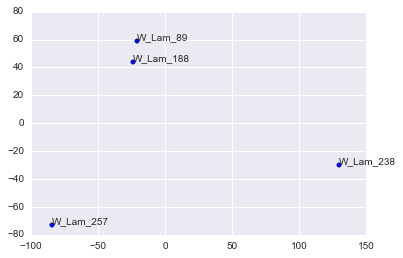

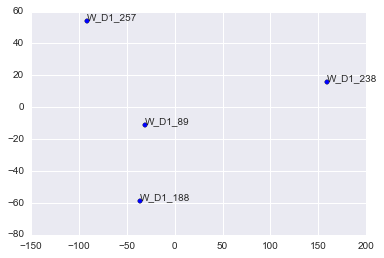

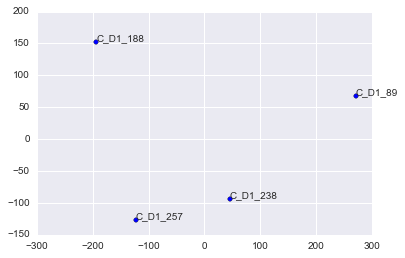

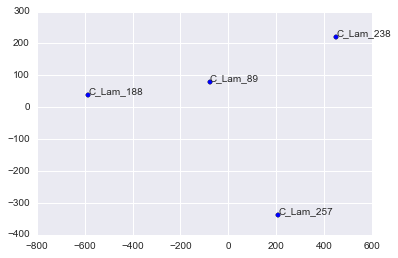

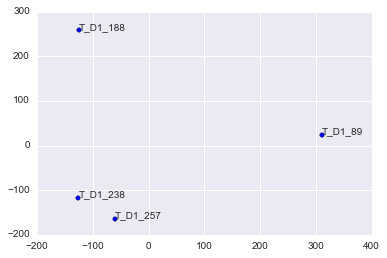

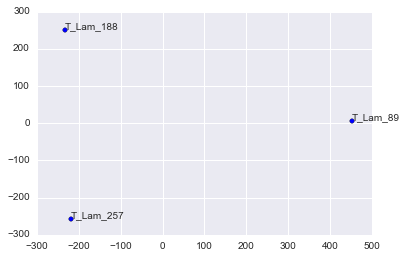

In [266]:
tissue='W'
protein="Lam"
pca = PCA(n_components=4)
X = pca.fit_transform(log2FC[pval[tissue + '_'+ protein] < .05].ix[:,19:].dropna().transpose())
plt.scatter(X[:,0],X[:,1])
for i,lab in enumerate(log2FC.ix[:,19:].columns):
    plt.annotate(lab, xy= (X[i,0], X[i,1]))   
plt.show()

tissue='W'
protein="D1"
pca = PCA(n_components=4)
X = pca.fit_transform(log2FC[pval[tissue + '_'+ protein] < .05].ix[:,15:19].dropna().transpose())
plt.scatter(X[:,0],X[:,1])
for i,lab in enumerate(log2FC.ix[:,15:19].columns):
    plt.annotate(lab, xy= (X[i,0], X[i,1]))
plt.show()

tissue='C'
protein="D1"
pca = PCA(n_components=4)
X = pca.fit_transform(log2FC[pval[tissue + '_'+ protein] < .05].ix[:,0:4].dropna().transpose())
plt.scatter(X[:,0],X[:,1])
for i,lab in enumerate(log2FC.ix[:,0:4].columns):
    plt.annotate(lab, xy= (X[i,0], X[i,1]))
plt.show()

tissue='C'
protein="Lam"
pca = PCA(n_components=4)
X = pca.fit_transform(log2FC[pval[tissue + '_'+ protein] < .05].ix[:,4:8].dropna().transpose())
plt.scatter(X[:,0],X[:,1])
for i,lab in enumerate(log2FC.ix[:,4:8].columns):
    plt.annotate(lab, xy= (X[i,0], X[i,1]))
plt.show()

tissue='T'
protein="D1"
pca = PCA(n_components=4)
X = pca.fit_transform(log2FC[pval[tissue + '_'+ protein] < .05].ix[:,8:12].dropna().transpose())
plt.scatter(X[:,0],X[:,1])
for i,lab in enumerate(log2FC.ix[:,8:12].columns):
    plt.annotate(lab, xy= (X[i,0], X[i,1]))
plt.show()

tissue='T'
protein="Lam"
pca = PCA(n_components=4)
X = pca.fit_transform(log2FC[pval[tissue + '_'+ protein] < .05].ix[:,12:15].dropna().transpose())
plt.scatter(X[:,0],X[:,1])
for i,lab in enumerate(log2FC.ix[:,12:15].columns):
    plt.annotate(lab, xy= (X[i,0], X[i,1]))
plt.show()

## Testing heterochromatic sink model

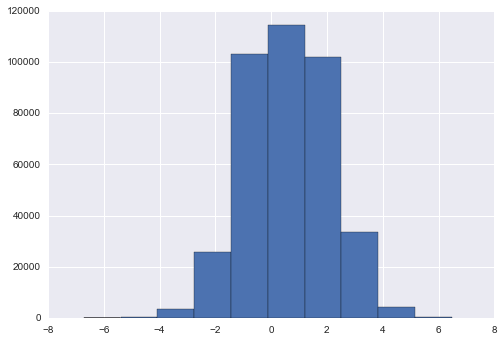

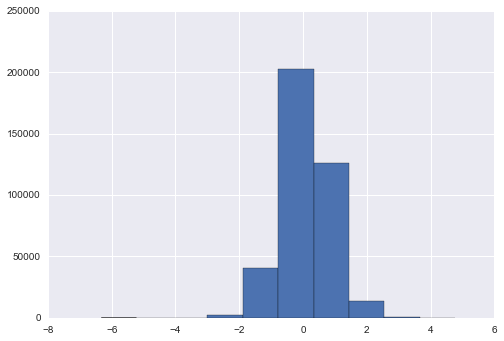

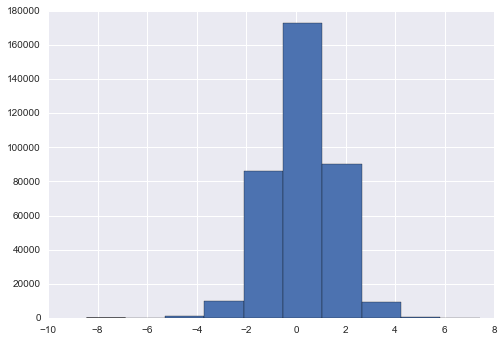

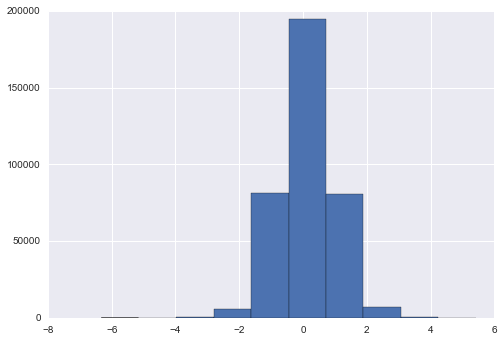

In [64]:
log2FC.C_D1_188.hist()
plt.show()
log2FC.C_D1_257.hist()
plt.show()
log2FC.C_D1_89.hist()
plt.show()
log2FC.C_D1_238.hist()
plt.show()

In [66]:
print log2FC.C_D1_188.mean()
print log2FC.C_D1_257.mean()
print log2FC.C_D1_89.mean()
print log2FC.C_D1_238.mean()

0.597780299354
0.0909143236972
0.222505753629
0.134448066914


The means do not match up with our results from C-D1 (5S-rRNA differentially bound - most lowly bound in C_D1_89).  Anova F test rejects null that means are the same

In [71]:
import scipy.stats

# Perform the ANOVA
scipy.stats.f_oneway(log2FC.C_D1_188.dropna(), log2FC.C_D1_257.dropna(),log2FC.C_D1_89.dropna(), log2FC.C_D1_238.dropna())

F_onewayResult(statistic=16284.337478314044, pvalue=0.0)

In [73]:
print log2FC.T_Lam_188.mean()
print log2FC.T_Lam_257.mean()
print log2FC.T_Lam_89.mean()

0.108767434594
0.600678515593
1.41803320221


The means do not match up with our results from T-Lam (5S-rRNA differentially bound - most lowly bound in T-Lam-257).

Now let's just look at regions that are differentially bound

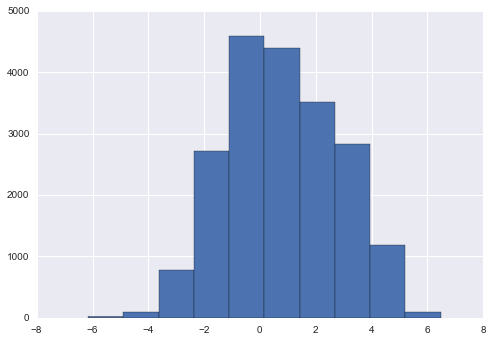

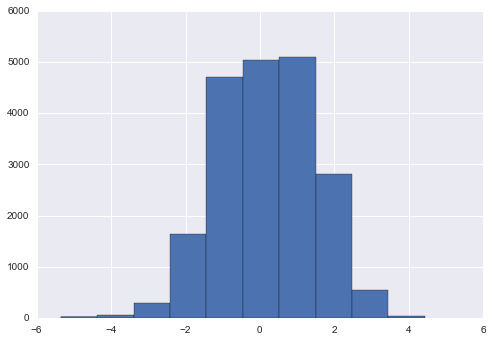

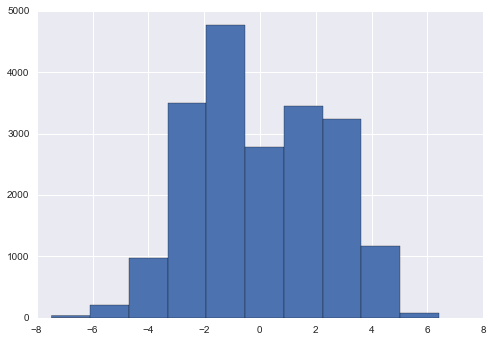

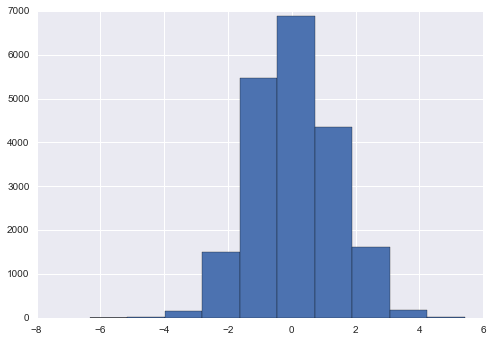

In [82]:
log2FC[pval.C_D1<.05].C_D1_188.hist()
plt.show()
log2FC[pval.C_D1<.05].C_D1_257.hist()
plt.show()
log2FC[pval.C_D1<.05].C_D1_89.hist()
plt.show()
log2FC[pval.C_D1<.05].C_D1_238.hist()
plt.show()

In [80]:
print log2FC[pval.C_D1<.05].C_D1_188.mean()
print log2FC[pval.C_D1<.05].C_D1_257.mean()
print log2FC[pval.C_D1<.05].C_D1_89.mean()
print log2FC[pval.C_D1<.05].C_D1_238.mean()

0.800176477539
0.194723535505
0.0326324631538
0.0774118038843


At least here 89 is the lowest, which would be consistent with the local heterochromatin sink model.  

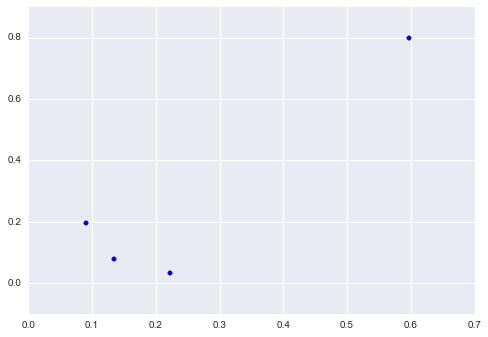

In [81]:
plt.scatter([log2FC.C_D1_188.mean(),log2FC.C_D1_257.mean(),log2FC.C_D1_89.mean(),log2FC.C_D1_238.mean()], [log2FC[pval.C_D1<.05].C_D1_188.mean(),log2FC[pval.C_D1<.05].C_D1_257.mean(),log2FC[pval.C_D1<.05].C_D1_89.mean(),log2FC[pval.C_D1<.05].C_D1_238.mean()])

## Create locations dataframe with heterochromatin state

In [3]:
chromatin_df=pd.read_csv("GSE22069_Drosophila_chromatin_domains.txt", sep='\t')
chromatin_df.head()

,seqname,start,end,chromatin
0,chr2L,5301,58754,BLACK
1,chr2L,58763,65319,BLUE
2,chr2L,65316,76559,RED
3,chr2L,76693,84511,BLUE
4,chr2L,84650,89599,RED


In [4]:
#chromatin_df.groupby('seqname').count()

,start,end,chromatin
seqname,,,
chr2L,1474,1474,1474
chr2R,1585,1585,1585
chr3L,1740,1740,1740
chr3R,1992,1992,1992
chr4,69,69,69
chrX,1568,1568,1568


Write to file so that you can update to version 6 using http://flybase.org/static_pages/downloads/COORD.html

In [19]:
#chromatin_df.dtypes

seqname      object
start         int64
end           int64
chromatin    object
ForUpdate    object
dtype: object

In [28]:
#chromatin_df["ForUpdate"]=chromatin_df.seqname[3:] + ':' + str(chromatin_df.start) + '..' + str(chromatin_df.end)
#chromatin_df["ForUpdate"]=chromatin_df.seqname.astype(str).apply(lambda x: x[3:]) + ':' +chromatin_df.start.astype(str)+ '..' + chromatin_df.end.astype(str)
#chromatin_df.head()

,seqname,start,end,chromatin,ForUpdate
0,chr2L,5301,58754,BLACK,2L:5301..58754
1,chr2L,58763,65319,BLUE,2L:58763..65319
2,chr2L,65316,76559,RED,2L:65316..76559
3,chr2L,76693,84511,BLUE,2L:76693..84511
4,chr2L,84650,89599,RED,2L:84650..89599


In [ ]:
#chromatin_df.ForUpdate.to_csv("20160625_Chromatin_state_v4_to_v6", index=False)

After having completed the steps above, you get the following updated file
After converted to v6, we get the following file: 
"FlyBase_Converted_Coordinates.txt"

In [1]:
%matplotlib inline

import glob
from string import letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import signal
from sklearn.decomposition import PCA

locations_df=pd.read_csv("Locations")
locations_df.head()

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


,Unnamed: 0,0,1,2
0,0,211000022278049,390,394
1,1,211000022278049,537,541
2,2,211000022278049,573,577
3,3,211000022278049,837,841
4,4,211000022278049,1613,1617


In [2]:
chromatin_df=pd.read_csv("GSE22069_Drosophila_chromatin_domains.txt", sep='\t')
chromatin_df.head()

,seqname,start,end,chromatin
0,chr2L,5301,58754,BLACK
1,chr2L,58763,65319,BLUE
2,chr2L,65316,76559,RED
3,chr2L,76693,84511,BLUE
4,chr2L,84650,89599,RED


In [3]:
Updated_chromatin_df = pd.read_csv("FlyBase_Converted_Coordinates.txt", sep="\t")
Updated_chromatin_df["seqname"] = Updated_chromatin_df.Converted.astype(str).apply(lambda x: x.split(':')[0])
Updated_chromatin_df["start"] = Updated_chromatin_df.Converted.astype(str).apply(lambda x: x.split(':')[1].split('..')[0])
Updated_chromatin_df["end"] = Updated_chromatin_df.Converted.astype(str).apply(lambda x: x.split(':')[1].split('..')[1])
del Updated_chromatin_df["Converted"]

Updated_chromatin_df.index = range(Updated_chromatin_df.shape[0])
Updated_chromatin_df["chromatin"] = chromatin_df.chromatin
Updated_chromatin_df.head()

,seqname,start,end,chromatin
0,2L,5301,58754,BLACK
1,2L,58763,65319,BLUE
2,2L,65316,76559,RED
3,2L,76693,84511,BLUE
4,2L,84650,89599,RED


In [4]:
del chromatin_df 

In [8]:
key='2R'
subset_chrom_df=Updated_chromatin_df[Updated_chromatin_df.seqname == key]
subset_chrom_df.ix[subset_chrom_df.index[51],'start']
#float(subset_chrom_df.ix[subset_chrom_df.index[1473],'start'])

'?'

In [10]:
locations_df.head()

,Unnamed: 0,0,1,2
0,0,211000022278049,390,394
1,1,211000022278049,537,541
2,2,211000022278049,573,577
3,3,211000022278049,837,841
4,4,211000022278049,1613,1617


In [33]:
#locations_df["chromatin_state"]=[np.nan for ele in locations_df['0']]
print locations_df.shape, "shape of restricted_locations_df"
key = 0
start = 0
for i,row1 in enumerate(locations_df[10000:].iterrows()):
    i = i + 10000
    if not i%1000:
        print i/1000,
    temp_key = str(row1[1]['0'])
    temp_start = str(row1[1]['1'])
    if temp_start < start:
        j = 0
    start = temp_start
    if key != temp_key:
        key = temp_key
        print key, 'key', 
        j = 0        
        subset_chrom_df=Updated_chromatin_df[Updated_chromatin_df.seqname == key]
        len_subset_chrom_df = subset_chrom_df.shape[0]
        print len_subset_chrom_df, 'shape'
    for j in range(j,len_subset_chrom_df):

        try:
            if float(row1[1]['1']) < float(subset_chrom_df.ix[subset_chrom_df.index[j],'start']):
                if j==0:
                    break
                else:
                    if float(row1[1]['2']) <= float(subset_chrom_df.loc[subset_chrom_df.index[j-1],'end']) and float(row1[1]['1']) >= float(subset_chrom_df.loc[subset_chrom_df.index[j-1],'start']) :
                        locations_df.ix[locations_df.index[i],' chromatin_state'] = subset_chrom_df.ix[subset_chrom_df.index[j-1],'chromatin']
                        j= j-1
                        break
                    j=j-1
                    break
        except:
            if str(subset_chrom_df.ix[subset_chrom_df.index[j],'start']) != '?' and str(subset_chrom_df.ix[subset_chrom_df.index[j-1],'end']) != '?':                
                print float(row1[1]['1'])
                print j

locations_df.head()

(388464, 5) shape of restricted_locations_df
10 2L key 1474 shape
11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 2R key 1585 shape
64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 2R2_mapped_Scaffold_56_D1828 key 0 shape
3Cen_mapped_Scaffold_1_D1896_D1895 key 0 shape
137 3Cen_mapped_Scaffold_27_D1777 key 0 shape
3Cen_mapped_Scaffold_31_D1643_D1653_D1791 key 0 shape
3Cen_mapped_Scaffold_36_D1605 key 0 shape
3Cen_mapped_Scaffold_41_D1641 key 0 shape
3Cen_mapped_Scaffold_50_D1686 key 0 shape
3L key 1740 shape
138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 1

,Unnamed: 0,0,1,2,chromatin_state
0,0,211000022278049,390,394,NaN
1,1,211000022278049,537,541,NaN
2,2,211000022278049,573,577,NaN
3,3,211000022278049,837,841,NaN
4,4,211000022278049,1613,1617,NaN


In [34]:
#locations_df.to_csv("locations_and_heterochromatin")

In [41]:
locations_df.groupby("chromatin_state").count()

,Unnamed: 0,0,1,2
chromatin_state,,,,
BLACK,138672,138672,138672,138672
BLUE,63202,63202,63202,63202
GREEN,17832,17832,17832,17832
RED,29435,29435,29435,29435
YELLOW,70005,70005,70005,70005


In [36]:
lFC=[]
lBM=[]
for f1 in glob.glob("res*"):
    df_FC = pd.read_csv(f1).log2FoldChange
    df_BM = pd.read_csv(f1).baseMean
    lFC.append(df_FC)
    lBM.append(df_BM)
log2FC = pd.concat(lFC, axis = 1)
baseM = pd.concat(lBM, axis = 1)

log2FC.columns= map(lambda x: x[8:], glob.glob("res*"))
log2FC.head()

baseM.columns= map(lambda x: x[8:], glob.glob("res*"))
baseM.head()

,C_D1_188,C_D1_238,C_D1_257,C_D1_89,C_Lam_188,C_Lam_238,C_Lam_257,C_Lam_89,T_D1_188,T_D1_238,...,T_Lam_257,T_Lam_89,W_D1_188,W_D1_238,W_D1_257,W_D1_89,W_Lam_188,W_Lam_238,W_Lam_257,W_Lam_89
0,0.632360,0.219583,0.617413,0.353553,1.423632,0.721288,1.313440,0.166012,1.382349,1.526687,...,0.942010,0.137624,0.667969,0.143726,0.611825,0.949658,0.649690,0.112728,0.568352,0.918350
1,0.444129,0.219583,0.502155,0.163913,1.013380,0.721288,1.087081,0.412760,1.208380,0.138335,...,0.646270,0.137624,0.825459,0.143726,0.310907,1.008575,0.829502,0.094104,0.521248,0.892944
2,0.444129,0.354546,0.502155,0.163913,1.013380,0.889381,0.923345,0.412760,1.323238,0.138335,...,0.646270,0.137624,0.825459,0.143726,0.310907,1.008575,0.829502,0.221549,0.521248,0.892944
3,0.514814,0.716185,0.797342,0.163913,0.410957,1.076175,0.829917,0.246748,0.711324,0.000000,...,0.080143,0.137624,0.785790,0.449538,0.681006,0.460453,0.431993,0.430985,0.323789,0.836915
4,1.048009,0.134962,0.598488,0.516430,1.459705,0.168094,0.788619,1.235139,0.363386,0.293382,...,0.761525,0.137624,0.327046,0.000000,0.462001,0.274345,0.379232,0.127445,0.667081,0.773114


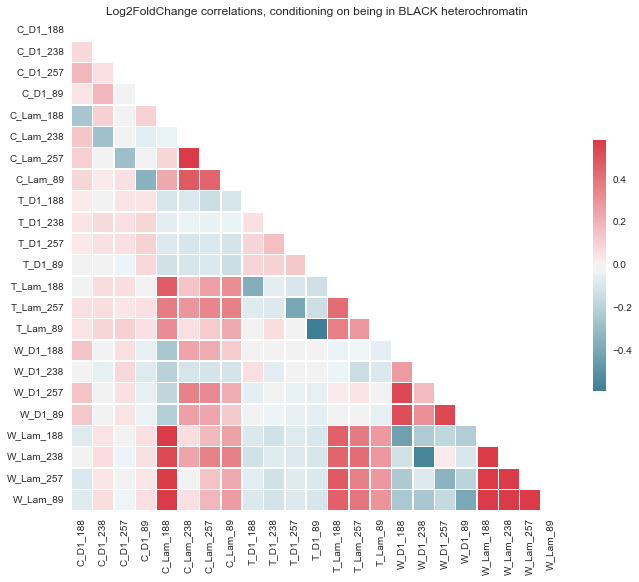

In [43]:
sns.set(style="white")

corr=log2FC[locations_df.chromatin_state=='BLACK'].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title("Log2FoldChange correlations, conditioning on being in BLACK heterochromatin")

When you condition on black heterochromatin state, you see no difference in these correlations, meaning that even in black where Lam binds negativey correlated to where D1 binds.

Below, we check that our heterochromatin states make sense: higher log2FC in regions of black, then blue, lower in green, yellow, red.

0.245067679555
0.0894203312076
-0.152676423712
-0.26238619942
-0.451712893705

6.69660265706
7.00002646849
6.30800729342
9.01152539264
6.99553264976


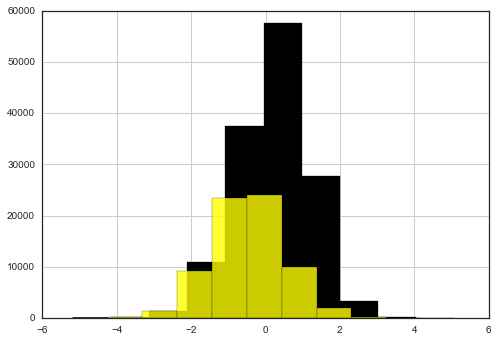

In [70]:
log2FC[locations_df.chromatin_state=="BLACK"].W_Lam_188.hist(color="black")
#log2FC[locations_df.chromatin_state=="RED"].C_Lam_188.hist(color="red")
log2FC[locations_df.chromatin_state=="YELLOW"].W_Lam_188.hist(color="yellow", alpha=.8)
#log2FC[locations_df.chromatin_state=="BLUE"].W_Lam_188.hist(color="blue", alpha=.5)

print log2FC[locations_df.chromatin_state=="BLACK"].W_Lam_188.mean()
print log2FC[locations_df.chromatin_state=="BLUE"].W_Lam_188.mean()
print log2FC[locations_df.chromatin_state=="GREEN"].W_Lam_188.mean()
print log2FC[locations_df.chromatin_state=="RED"].W_Lam_188.mean()
print log2FC[locations_df.chromatin_state=="YELLOW"].W_Lam_188.mean()
print
print baseM[locations_df.chromatin_state=="BLACK"].W_Lam_188.mean()
print baseM[locations_df.chromatin_state=="BLUE"].W_Lam_188.mean()
print baseM[locations_df.chromatin_state=="GREEN"].W_Lam_188.mean()
print baseM[locations_df.chromatin_state=="RED"].W_Lam_188.mean()
print baseM[locations_df.chromatin_state=="YELLOW"].W_Lam_188.mean()

D1 binding is quite high in yellow, and low in black.

-0.0348119039164
0.004329813984
-0.0311308309685
-0.00161008908828
0.0467955518144

5.49972744499
5.97322102921
6.29228678362
9.15842302318
7.35993627936


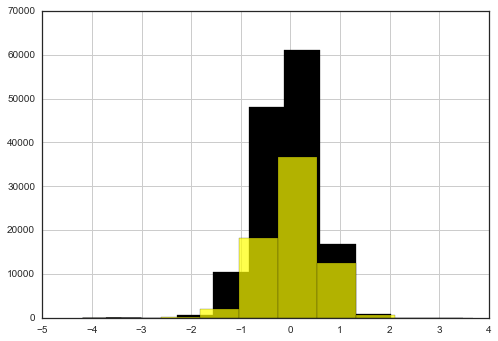

In [72]:
log2FC[locations_df.chromatin_state=="BLACK"].W_D1_188.hist(color="black")
#log2FC[locations_df.chromatin_state=="RED"].C_Lam_188.hist(color="red")
log2FC[locations_df.chromatin_state=="YELLOW"].W_D1_188.hist(color="yellow", alpha=.7)
#log2FC[locations_df.chromatin_state=="BLUE"].W_D1_188.hist(color="blue", alpha=.5)


print log2FC[locations_df.chromatin_state=="BLACK"].W_D1_188.mean()
print log2FC[locations_df.chromatin_state=="BLUE"].W_D1_188.mean()
print log2FC[locations_df.chromatin_state=="GREEN"].W_D1_188.mean()
print log2FC[locations_df.chromatin_state=="RED"].W_D1_188.mean()
print log2FC[locations_df.chromatin_state=="YELLOW"].W_D1_188.mean()
print
print baseM[locations_df.chromatin_state=="BLACK"].W_D1_188.mean()
print baseM[locations_df.chromatin_state=="BLUE"].W_D1_188.mean()
print baseM[locations_df.chromatin_state=="GREEN"].W_D1_188.mean()
print baseM[locations_df.chromatin_state=="RED"].W_D1_188.mean()
print baseM[locations_df.chromatin_state=="YELLOW"].W_D1_188.mean()

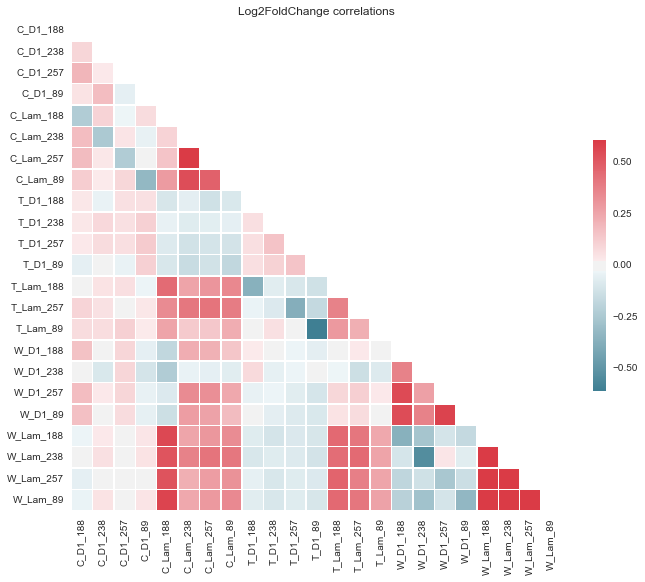

In [71]:
sns.set(style="white")

corr=log2FC[locations_df.chromatin_state=='YELLOW'].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title("Log2FoldChange correlations")

## Comparing regions where differential expression to regions of differential binding

In [5]:
diff_expression_locations=[]
fp=open("FlyBase_FastA_differentially_expressed_carcass.txt", "r")
for line in fp:
    if line[0]=='>':
        diff_expression_locations.append(line.split(";")[1])
fp.close()

In [10]:
print len(diff_expression_locations)

443


In [6]:
diff_expression_locations[:10]

[' loc=X:245978..254650',
 ' loc=X:complement(585081..620195)',
 ' loc=X:complement(946662..947500)',
 ' loc=X:complement(2278031..2293411)',
 ' loc=X:complement(2622069..2624575)',
 ' loc=X:2948034..2949120',
 ' loc=X:complement(2885186..2885914)',
 ' loc=X:4939128..4955916',
 ' loc=X:5421533..5427219',
 ' loc=X:complement(6349016..6350401)']

We remove the word complement

In [33]:
diff_expression_locations_no_complement =[ele.replace('complement(','') for ele in diff_expression_locations]
diff_expression_locations_no_complement = [ele.strip(')') for ele in diff_expression_locations_no_complement]
diff_expression_locations_no_complement[:10]


['X:245978..254650',
 'X:585081..620195',
 'X:946662..947500',
 'X:2278031..2293411',
 'X:2622069..2624575',
 'X:2948034..2949120',
 'X:2885186..2885914',
 'X:4939128..4955916',
 'X:5421533..5427219',
 'X:6349016..6350401']

In [34]:
diff_expression_df=pd.DataFrame()
diff_expression_df["chr"]=[ele.split(":")[0] for ele in diff_expression_locations_no_complement]
diff_expression_df["start"]=[ele.split(":")[1].split("..")[0] for ele in diff_expression_locations_no_complement]
diff_expression_df["end"]=[ele.split("..")[1] for ele in diff_expression_locations_no_complement]
diff_expression_df.head()

,chr,start,end
0,X,245978,254650
1,X,585081,620195
2,X,946662,947500
3,X,2278031,2293411
4,X,2622069,2624575


In [35]:
diff_expression_df["chromatin_state"]=[np.nan for ele in diff_expression_df['chr']]
#print locations_df.shape, "shape of restricted_locations_df"
key = 0
start = 0
for i,row1 in enumerate(diff_expression_df.iterrows()):
    print i,
    key = str(row1[1]['chr'])     
    subset_chrom_df=Updated_chromatin_df[Updated_chromatin_df.seqname == key]
    len_subset_chrom_df = subset_chrom_df.shape[0]
    #print len_subset_chrom_df, 'shape'
    for j in range(len_subset_chrom_df):
        try:
            if float(row1[1]['end']) <= float(subset_chrom_df.loc[subset_chrom_df.index[j],'end']) and float(row1[1]['start']) >= float(subset_chrom_df.loc[subset_chrom_df.index[j],'start']) :
                    diff_expression_df.ix[diff_expression_df.index[i],'chromatin_state'] = subset_chrom_df.ix[subset_chrom_df.index[j],'chromatin']
                    break
        except:
            pass
            #print j,
            #print subset_chrom_df.loc[subset_chrom_df.index[j]]

diff_expression_df.head(n=20)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

,chr,start,end,chromatin_state
0,X,245978,254650,BLACK
1,X,585081,620195,NaN
2,X,946662,947500,NaN
3,X,2278031,2293411,NaN
4,X,2622069,2624575,YELLOW
5,X,2948034,2949120,BLACK
6,X,2885186,2885914,BLACK
7,X,4939128,4955916,NaN
8,X,5421533,5427219,BLACK
9,X,6349016,6350401,YELLOW


In [38]:
diff_expression_df.groupby("chromatin_state").count()

,chr,start,end
chromatin_state,,,
BLACK,128,128,128
BLUE,43,43,43
GREEN,9,9,9
RED,10,10,10
YELLOW,84,84,84


not clear that most of these differentially epxressed genes are in black or blue.  Seems in fact like there are a lot more in 'yellow.'

In [107]:
locations_df.groupby("chromatin_state").count()

,Unnamed: 0,0,1,2
chromatin_state,,,,
BLACK,138672,138672,138672,138672
BLUE,63202,63202,63202,63202
GREEN,17832,17832,17832,17832
RED,29435,29435,29435,29435
YELLOW,70005,70005,70005,70005


In [108]:
138672/319146.0

0.4345095974882969

In [39]:
128/274.0

0.46715328467153283

## Let's now correlate these DamID and diff expr dataframes

Find areas of differential binding in locations df

In [41]:
locations_df.head()

,Unnamed: 0,0,1,2
0,0,211000022278049,390,394
1,1,211000022278049,537,541
2,2,211000022278049,573,577
3,3,211000022278049,837,841
4,4,211000022278049,1613,1617


In [43]:
locations_df["contains_diff_expr_gene"]=[0 for ele in locations_df['0']]
key = 0
start = 0
for i,row1 in enumerate(diff_expression_df.iterrows()):
    print i,
    key = str(row1[1]['chr'])     
    subset_locations_df=locations_df[locations_df['0'] == key]
    len_locations_df = subset_locations_df.shape[0]
    #print len_subset_chrom_df, 'shape'
    for j in range(len_locations_df):
        try:
            if float(row1[1]['end']) <= float(subset_locations_df.loc[subset_locations_df.index[j],'end']) and float(row1[1]['start']) >= float(subset_locations_df.loc[subset_locations_df.index[j],'start']) :
                    locations_df.ix[locations_df.index[j],'contains_diff_expr_gene'] = 1
                    break
        except:
            pass
            #print j,
            #print subset_chrom_df.loc[subset_chrom_df.index[j]]

diff_expression_df.head(n=20)

 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 2

,chr,start,end,chromatin_state
0,X,245978,254650,BLACK
1,X,585081,620195,NaN
2,X,946662,947500,NaN
3,X,2278031,2293411,NaN
4,X,2622069,2624575,YELLOW
5,X,2948034,2949120,BLACK
6,X,2885186,2885914,BLACK
7,X,4939128,4955916,NaN
8,X,5421533,5427219,BLACK
9,X,6349016,6350401,YELLOW


In [ ]:
for f1 in glob.glob("nbin*"):
    df_padj = pd.read_csv(f1).padj
    df_pval = pd.read_csv(f1).pvalue
    lpadj.append(df_padj)
    lpval.append(df_pval)
pval = pd.concat(lpval, axis = 1)
padj = pd.concat(lpadj, axis = 1)

pval.columns= map(lambda x: x[25:], glob.glob("nbin*"))
pval.head()

padj.columns= map(lambda x: x[25:], glob.glob("nbin*"))
padj.head()